In [31]:
# Cell 1: 导入依赖库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os

# 使用sklearn的梯度提升树 (避免OpenMP依赖问题)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
import shap

# Sklearn工具
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)

# 中文显示配置
import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['STHeiti', 'SimHei', 'Arial Unicode MS']
else:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 8)

sns.set_theme(style='whitegrid')

# 创建输出目录
os.makedirs('figs', exist_ok=True)
os.makedirs('results', exist_ok=True)

print('✓ 依赖加载完成')
print(f'  SHAP版本: {shap.__version__}')
print('  模型: GradientBoostingRegressor (sklearn)')

✓ 依赖加载完成
  SHAP版本: 0.49.1
  模型: GradientBoostingRegressor (sklearn)


## 1. 数据加载与特征工程

In [32]:
# Cell 2: 加载选手汇总表
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题1_完整分析/问题1_选手汇总表.csv'
MAIN_DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'

df_summary = pd.read_csv(DATA_PATH)
df_main = pd.read_csv(MAIN_DATA_PATH)

print('='*70)
print('数据加载摘要')
print('='*70)
print(f'选手汇总表: {df_summary.shape[0]} 行 × {df_summary.shape[1]} 列')
print(f'有粉丝投票估计: {df_summary["fan_vote_estimate"].notna().sum()} 人')
print(f'决赛选手: {df_summary["is_finalist"].sum()} 人')
print(f'\n目标变量统计:')
print(f'  评委得分: [{df_summary["season_avg_score"].min():.2f}, {df_summary["season_avg_score"].max():.2f}]')
print(f'  粉丝投票: [{df_summary["fan_vote_estimate"].min():.4f}, {df_summary["fan_vote_estimate"].max():.4f}]')
print(f'  最终排名: [{df_summary["placement"].min()}, {df_summary["placement"].max()}]')

数据加载摘要
选手汇总表: 408 行 × 29 列
有粉丝投票估计: 395 人
决赛选手: 108 人

目标变量统计:
  评委得分: [3.50, 9.52]
  粉丝投票: [0.0040, 0.7473]
  最终排名: [1, 16]


In [33]:
# Cell 3: 特征工程 - 计算专业舞者影响力指标

def calculate_partner_power(df):
    """
    计算专业舞者影响力指标 PartnerPower
    = 0.4 × 标准化(历史平均得分) + 0.4 × 标准化(历史平均存活周数) + 0.2 × 标准化(决赛次数)
    """
    # 基础统计
    partner_stats = df.groupby('ballroom_partner').agg({
        'season_avg_score': 'mean',
        'weeks_survived': 'mean',
        'celebrity_name': 'count',
        'is_finalist': 'sum'
    }).reset_index()
    
    partner_stats.columns = ['ballroom_partner', 'partner_avg_score', 'partner_avg_weeks', 
                              'partner_total_celebs', 'partner_finalist_count']
    
    # 标准化后加权计算 PartnerPower
    scaler = StandardScaler()
    partner_stats['score_z'] = scaler.fit_transform(partner_stats[['partner_avg_score']])
    partner_stats['weeks_z'] = scaler.fit_transform(partner_stats[['partner_avg_weeks']])
    partner_stats['finalist_z'] = scaler.fit_transform(partner_stats[['partner_finalist_count']])
    
    # PartnerPower = 0.4*得分 + 0.4*存活周数 + 0.2*决赛次数
    partner_stats['PartnerPower'] = (0.4 * partner_stats['score_z'] + 
                                      0.4 * partner_stats['weeks_z'] + 
                                      0.2 * partner_stats['finalist_z'])
    
    return partner_stats[['ballroom_partner', 'partner_avg_score', 'partner_avg_weeks', 
                          'partner_finalist_count', 'PartnerPower']]

# 计算PartnerPower
partner_power = calculate_partner_power(df_summary)

# 合并到主数据
df = df_summary.merge(partner_power, on='ballroom_partner', how='left')

print('='*70)
print('专业舞者影响力排名 (Top 10)')
print('='*70)
top_partners = partner_power.nlargest(10, 'PartnerPower')
for i, row in top_partners.iterrows():
    print(f'  {row["ballroom_partner"]}: PartnerPower={row["PartnerPower"]:.3f} '
          f'(得分{row["partner_avg_score"]:.2f}, 周数{row["partner_avg_weeks"]:.1f}, 决赛{int(row["partner_finalist_count"])}次)')

专业舞者影响力排名 (Top 10)
  Derek Hough: PartnerPower=1.861 (得分8.85, 周数10.0, 决赛8次)
  Mark Ballas: PartnerPower=1.583 (得分8.36, 周数8.5, 决赛10次)
  Witney Carson (Xoshitl Gomez week 9): PartnerPower=1.428 (得分8.84, 周数11.0, 决赛1次)
  Val Chmerkovskiy (Joey Graziadei week 9): PartnerPower=1.409 (得分8.79, 周数11.0, 决赛1次)
  Valentin Chmerkovskiy: PartnerPower=1.399 (得分8.33, 周数8.5, 决赛8次)
  Ezra Sosa (Apolo Anton Ohno week 9): PartnerPower=1.326 (得分8.59, 周数11.0, 决赛1次)
  Charlotte Jorgensen: PartnerPower=1.108 (得分8.06, 周数11.0, 决赛1次)
  Cheryl Burke: PartnerPower=1.084 (得分7.59, 周数8.4, 决赛8次)
  Sasha Farber: PartnerPower=0.973 (得分8.13, 周数8.4, 决赛4次)
  Witney Carson: PartnerPower=0.948 (得分7.90, 周数7.8, 决赛6次)


In [34]:
# Cell 4: 准备建模数据集

# 选择特征列
feature_cols = [
    # 名人基础特征
    'celebrity_age',           # 年龄
    'is_international',        # 是否国际选手
    'season',                   # 赛季（时间效应）
    
    # 行业类型（One-Hot）
    'is_Actor_Actress',
    'is_Athlete',
    'is_TV_Personality',
    'is_Singer_Rapper',
    'is_Model',
    'is_Comedian',
    'is_Social_Media_Personality',
    'is_Radio_Personality',
    
    # 专业舞者特征
    'PartnerPower',            # 舞者综合实力
]

# 目标变量
target_judge = 'season_avg_score'     # 评委得分（回归）
target_fan = 'fan_vote_estimate'      # 粉丝投票（回归）
target_rank = 'placement'             # 最终排名（排序回归）

# 过滤有效数据（需要有粉丝投票估计）
df_model = df[df['fan_vote_estimate'].notna()].copy()

# 填充缺失的PartnerPower
df_model['PartnerPower'] = df_model['PartnerPower'].fillna(0)

# 提取特征矩阵和目标向量
X = df_model[feature_cols].copy()
y_judge = df_model[target_judge].values
y_fan = df_model[target_fan].values
y_rank = df_model[target_rank].values

# 特征名称（用于SHAP可视化）
feature_names = [
    '年龄', '国际选手', '赛季',
    '演员', '运动员', '电视名人', '歌手/说唱', '模特', '喜剧演员', '网红', '电台主持',
    '舞伴实力'
]

print('='*70)
print('建模数据集准备完成')
print('='*70)
print(f'样本数: {len(X)}')
print(f'特征数: {len(feature_cols)}')
print(f'\n特征列表:')
for i, (col, name) in enumerate(zip(feature_cols, feature_names)):
    print(f'  {i+1}. {col} → {name}')

print(f'\n目标变量统计:')
print(f'  评委得分: mean={y_judge.mean():.2f}, std={y_judge.std():.2f}')
print(f'  粉丝投票: mean={y_fan.mean():.4f}, std={y_fan.std():.4f}')
print(f'  最终排名: mean={y_rank.mean():.1f}, range=[{y_rank.min()}, {y_rank.max()}]')

建模数据集准备完成
样本数: 395
特征数: 12

特征列表:
  1. celebrity_age → 年龄
  2. is_international → 国际选手
  3. season → 赛季
  4. is_Actor_Actress → 演员
  5. is_Athlete → 运动员
  6. is_TV_Personality → 电视名人
  7. is_Singer_Rapper → 歌手/说唱
  8. is_Model → 模特
  9. is_Comedian → 喜剧演员
  10. is_Social_Media_Personality → 网红
  11. is_Radio_Personality → 电台主持
  12. PartnerPower → 舞伴实力

目标变量统计:
  评委得分: mean=7.39, std=1.32
  粉丝投票: mean=0.1004, std=0.1625
  最终排名: mean=6.7, range=[1, 16]


## 2. GradientBoosting模型训练

### 模型配置
- **正则化**：max_depth限制 + min_samples_leaf防止过拟合
- **交叉验证**：5-Fold CV评估模型稳定性
- **目标函数**：
  - 回归任务：$\mathcal{L} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
  - 学习率控制：逐步逼近最优解

In [35]:
# Cell 5: 定义GradientBoostingRegressor模型参数

# 通用参数（控制过拟合）
gb_params = {
    'n_estimators': 100,
    'max_depth': 4,              # 限制树深度
    'learning_rate': 0.1,
    'min_samples_leaf': 5,       # 最小叶子样本数
    'subsample': 0.8,            # 行采样
    'max_features': 0.8,         # 列采样
    'random_state': 42
}

# 训练-测试集划分
X_train, X_test, y_judge_train, y_judge_test, y_fan_train, y_fan_test, y_rank_train, y_rank_test = \
    train_test_split(X, y_judge, y_fan, y_rank, test_size=0.2, random_state=42)

print(f'训练集: {len(X_train)} 样本')
print(f'测试集: {len(X_test)} 样本')
print(f'\nGradientBoostingRegressor参数:')
for k, v in gb_params.items():
    print(f'  {k}: {v}')

训练集: 316 样本
测试集: 79 样本

GradientBoostingRegressor参数:
  n_estimators: 100
  max_depth: 4
  learning_rate: 0.1
  min_samples_leaf: 5
  subsample: 0.8
  max_features: 0.8
  random_state: 42


In [36]:
# Cell 6: 训练三个GradientBoosting模型

# ====== 模型1：评委得分预测 ======
model_judge = GradientBoostingRegressor(**gb_params)
model_judge.fit(X_train, y_judge_train)
y_judge_pred = model_judge.predict(X_test)

# 5-Fold交叉验证
cv_scores_judge = cross_val_score(model_judge, X, y_judge, cv=5, scoring='r2')

print('='*70)
print('模型1: 评委得分预测 (GradientBoostingRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_judge_test, y_judge_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_judge_test, y_judge_pred)):.4f}')
print(f'  5-Fold CV R²: {cv_scores_judge.mean():.4f} ± {cv_scores_judge.std():.4f}')

# ====== 模型2：粉丝投票预测 ======
model_fan = GradientBoostingRegressor(**gb_params)
model_fan.fit(X_train, y_fan_train)
y_fan_pred = model_fan.predict(X_test)

cv_scores_fan = cross_val_score(model_fan, X, y_fan, cv=5, scoring='r2')

print('\n' + '='*70)
print('模型2: 粉丝投票预测 (GradientBoostingRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_fan_test, y_fan_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_fan_test, y_fan_pred)):.6f}')
print(f'  5-Fold CV R²: {cv_scores_fan.mean():.4f} ± {cv_scores_fan.std():.4f}')

# ====== 模型3：最终排名预测 ======
model_rank = GradientBoostingRegressor(**gb_params)
model_rank.fit(X_train, y_rank_train)
y_rank_pred = model_rank.predict(X_test)

cv_scores_rank = cross_val_score(model_rank, X, y_rank, cv=5, scoring='neg_mean_squared_error')

print('\n' + '='*70)
print('模型3: 最终排名预测 (GradientBoostingRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_rank_test, y_rank_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_rank_test, y_rank_pred)):.2f}')
print(f'  5-Fold CV RMSE: {np.sqrt(-cv_scores_rank.mean()):.2f} ± {np.sqrt(cv_scores_rank.std()):.2f}')

模型1: 评委得分预测 (GradientBoostingRegressor)
  测试集R²: 0.2309
  测试集RMSE: 1.1692
  5-Fold CV R²: 0.1769 ± 0.1332

模型2: 粉丝投票预测 (GradientBoostingRegressor)
  测试集R²: -0.1368
  测试集RMSE: 0.202516
  5-Fold CV R²: -0.1486 ± 0.1569

模型2: 粉丝投票预测 (GradientBoostingRegressor)
  测试集R²: -0.1368
  测试集RMSE: 0.202516
  5-Fold CV R²: -0.1486 ± 0.1569

模型3: 最终排名预测 (GradientBoostingRegressor)
  测试集R²: -0.0153
  测试集RMSE: 3.59
  5-Fold CV RMSE: 4.23 ± 2.50

模型3: 最终排名预测 (GradientBoostingRegressor)
  测试集R²: -0.0153
  测试集RMSE: 3.59
  5-Fold CV RMSE: 4.23 ± 2.50


## 3. SHAP值计算与可解释性分析

### SHAP核心概念
- **全局影响度**：$I_k = \frac{1}{n}\sum_{i=1}^{n}|\phi_k^{(i)}|$ （特征k的平均绝对贡献）
- **影响方向**：$\phi_k > 0$ 表示正向影响，$\phi_k < 0$ 表示负向影响
- **偏好差异**：$\Delta_k = I_k^{\text{judge}} - I_k^{\text{fan}}$ （法官vs粉丝的特征偏好差异）

In [37]:
# Cell 7: 计算SHAP值

# 使用TreeExplainer（针对树模型优化）
explainer_judge = shap.TreeExplainer(model_judge)
explainer_fan = shap.TreeExplainer(model_fan)
explainer_rank = shap.TreeExplainer(model_rank)

# 计算全量数据的SHAP值
shap_values_judge = explainer_judge.shap_values(X)
shap_values_fan = explainer_fan.shap_values(X)
shap_values_rank = explainer_rank.shap_values(X)

print('='*70)
print('SHAP值计算完成')
print('='*70)
print(f'SHAP矩阵维度: {shap_values_judge.shape}')
print(f'  样本数: {shap_values_judge.shape[0]}')
print(f'  特征数: {shap_values_judge.shape[1]}')

SHAP值计算完成
SHAP矩阵维度: (395, 12)
  样本数: 395
  特征数: 12


In [38]:
# Cell 8: 计算全局特征影响度

# 特征影响度 = 平均绝对SHAP值
importance_judge = np.abs(shap_values_judge).mean(axis=0)
importance_fan = np.abs(shap_values_fan).mean(axis=0)
importance_rank = np.abs(shap_values_rank).mean(axis=0)

# 标准化（便于比较）
def normalize(x):
    return x / x.sum()

importance_judge_norm = normalize(importance_judge)
importance_fan_norm = normalize(importance_fan)
importance_rank_norm = normalize(importance_rank)

# 汇总表
importance_df = pd.DataFrame({
    '特征': feature_names,
    '特征代码': feature_cols,
    '评委得分_SHAP': importance_judge,
    '粉丝投票_SHAP': importance_fan,
    '最终排名_SHAP': importance_rank,
    '评委得分_归一化': importance_judge_norm,
    '粉丝投票_归一化': importance_fan_norm,
    '最终排名_归一化': importance_rank_norm
})

# 计算法官vs粉丝的偏好差异
importance_df['偏好差异'] = importance_df['评委得分_归一化'] - importance_df['粉丝投票_归一化']
importance_df = importance_df.sort_values('评委得分_SHAP', ascending=False)

print('='*70)
print('全局特征影响度（SHAP）')
print('='*70)
print(importance_df[['特征', '评委得分_归一化', '粉丝投票_归一化', '偏好差异']].to_string(index=False))

全局特征影响度（SHAP）
   特征  评委得分_归一化  粉丝投票_归一化      偏好差异
   年龄  0.347708  0.354125 -0.006417
 舞伴实力  0.250463  0.307717 -0.057254
   赛季  0.143790  0.155999 -0.012209
   演员  0.084857  0.049903  0.034955
 电视名人  0.059448  0.020522  0.038926
  运动员  0.038487  0.044446 -0.005959
 喜剧演员  0.026567  0.000000  0.026567
歌手/说唱  0.019447  0.026732 -0.007285
 国际选手  0.013254  0.034969 -0.021715
   模特  0.011601  0.004378  0.007223
   网红  0.004379  0.001210  0.003169
 电台主持  0.000000  0.000000  0.000000


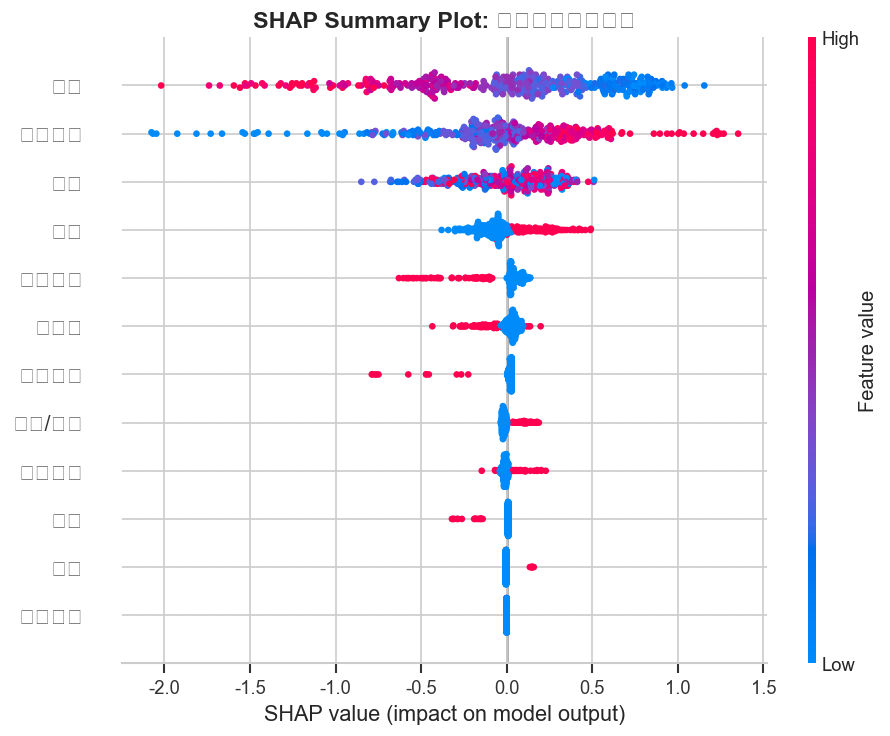

✓ 图表已保存: figs/问题4_SHAP_评委得分.png


In [39]:
# Cell 9: SHAP Summary Plot - 评委得分模型

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_judge, X, 
    feature_names=feature_names,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary Plot: 评委得分影响因素', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/问题4_SHAP_评委得分.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP_评委得分.png')

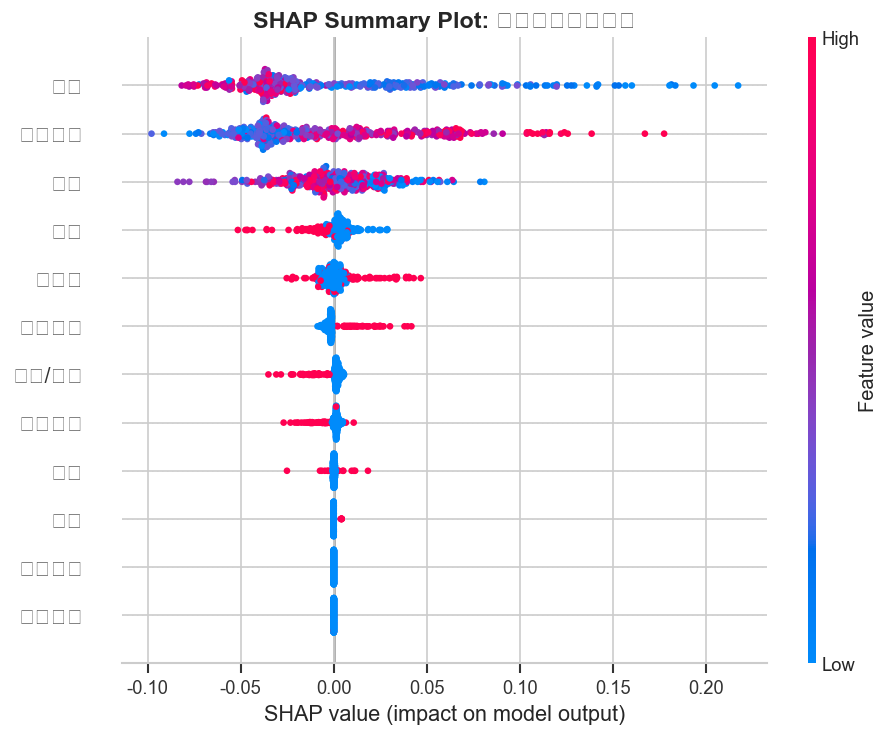

✓ 图表已保存: figs/问题4_SHAP_粉丝投票.png


In [40]:
# Cell 10: SHAP Summary Plot - 粉丝投票模型

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_fan, X, 
    feature_names=feature_names,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary Plot: 粉丝投票影响因素', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/问题4_SHAP_粉丝投票.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP_粉丝投票.png')

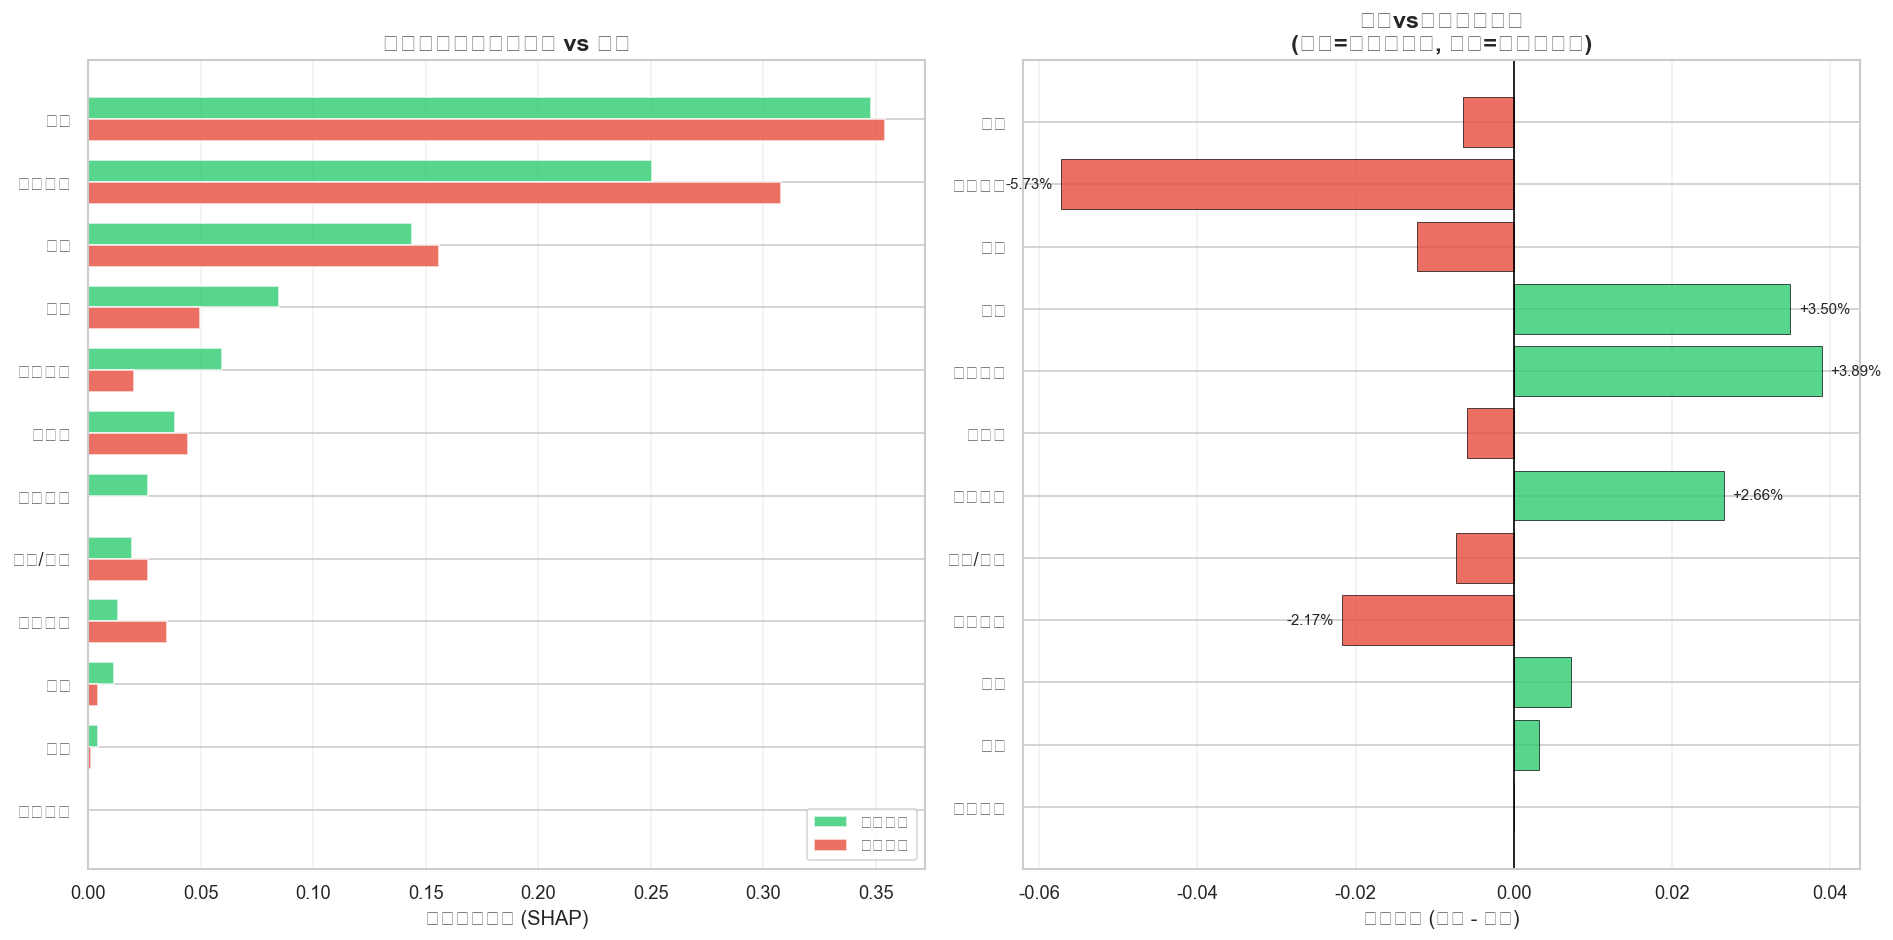

✓ 图表已保存: figs/问题4_法官vs粉丝_特征偏好对比.png


In [41]:
# Cell 11: 法官vs粉丝 特征影响度对比图

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 按评委得分影响度排序
sorted_idx = np.argsort(importance_judge)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# 左图：影响度对比条形图
ax1 = axes[0]
y_pos = np.arange(len(feature_names))
width = 0.35

bars1 = ax1.barh(y_pos - width/2, importance_judge_norm[sorted_idx], width, 
                  label='评委得分', color='#2ecc71', alpha=0.8)
bars2 = ax1.barh(y_pos + width/2, importance_fan_norm[sorted_idx], width, 
                  label='粉丝投票', color='#e74c3c', alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_features)
ax1.invert_yaxis()
ax1.set_xlabel('标准化影响度 (SHAP)', fontsize=12)
ax1.set_title('特征影响度对比：评委 vs 粉丝', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 右图：偏好差异图
ax2 = axes[1]
diff = importance_df.set_index('特征')['偏好差异'].reindex(sorted_features).values
colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in diff]

ax2.barh(y_pos, diff, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_features)
ax2.invert_yaxis()
ax2.set_xlabel('偏好差异 (评委 - 粉丝)', fontsize=12)
ax2.set_title('法官vs粉丝偏好差异\n(正值=法官更看重, 负值=粉丝更看重)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 添加标签
for i, (d, f) in enumerate(zip(diff, sorted_features)):
    if abs(d) > 0.02:
        ax2.annotate(f'{d:+.2%}', xy=(d, i), 
                     xytext=(5 if d > 0 else -5, 0),
                     textcoords='offset points',
                     ha='left' if d > 0 else 'right',
                     va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figs/问题4_法官vs粉丝_特征偏好对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_法官vs粉丝_特征偏好对比.png')

## 4. 关键特征深度分析

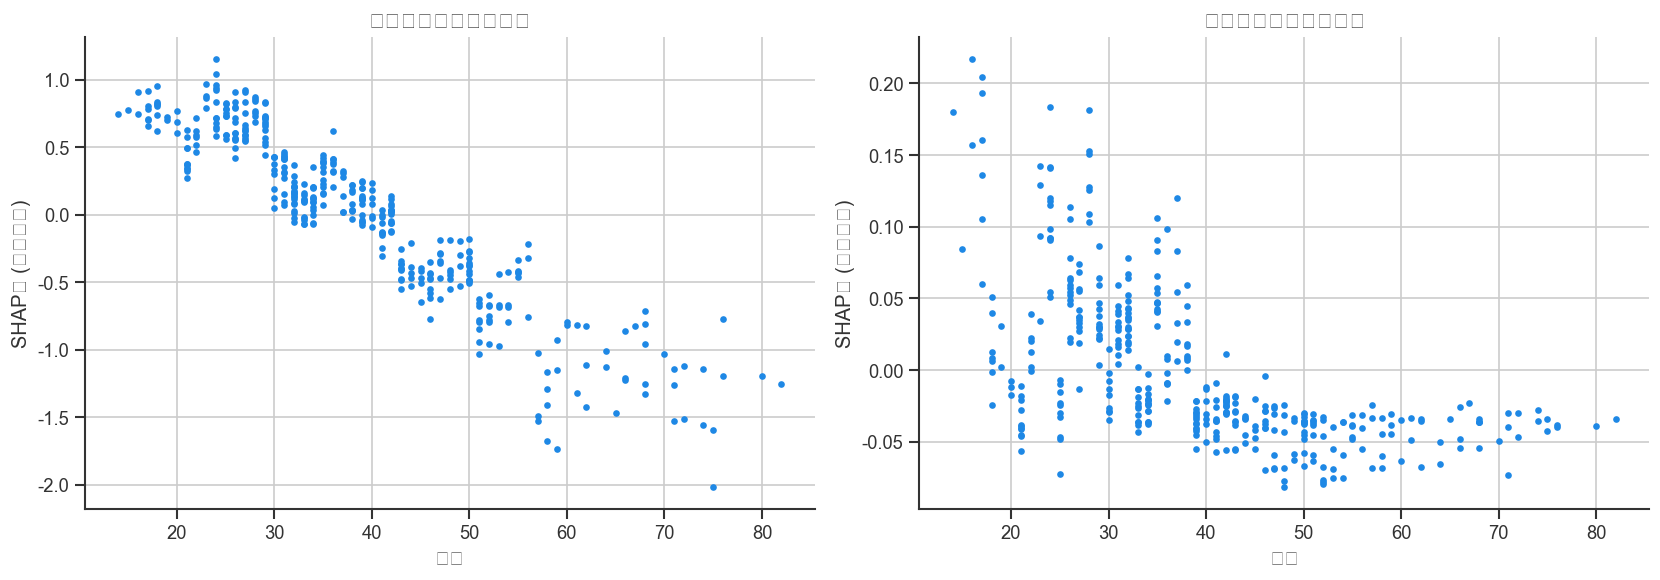

✓ 图表已保存: figs/问题4_年龄效应分析.png


In [42]:
# Cell 12: SHAP Dependence Plot - 年龄的非线性效应

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 年龄 vs 评委得分
shap.dependence_plot(
    'celebrity_age', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('年龄', fontsize=12)
axes[0].set_ylabel('SHAP值 (评委得分)', fontsize=12)
axes[0].set_title('年龄对评委得分的影响', fontsize=13, fontweight='bold')

# 年龄 vs 粉丝投票
shap.dependence_plot(
    'celebrity_age', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('年龄', fontsize=12)
axes[1].set_ylabel('SHAP值 (粉丝投票)', fontsize=12)
axes[1].set_title('年龄对粉丝投票的影响', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_年龄效应分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_年龄效应分析.png')

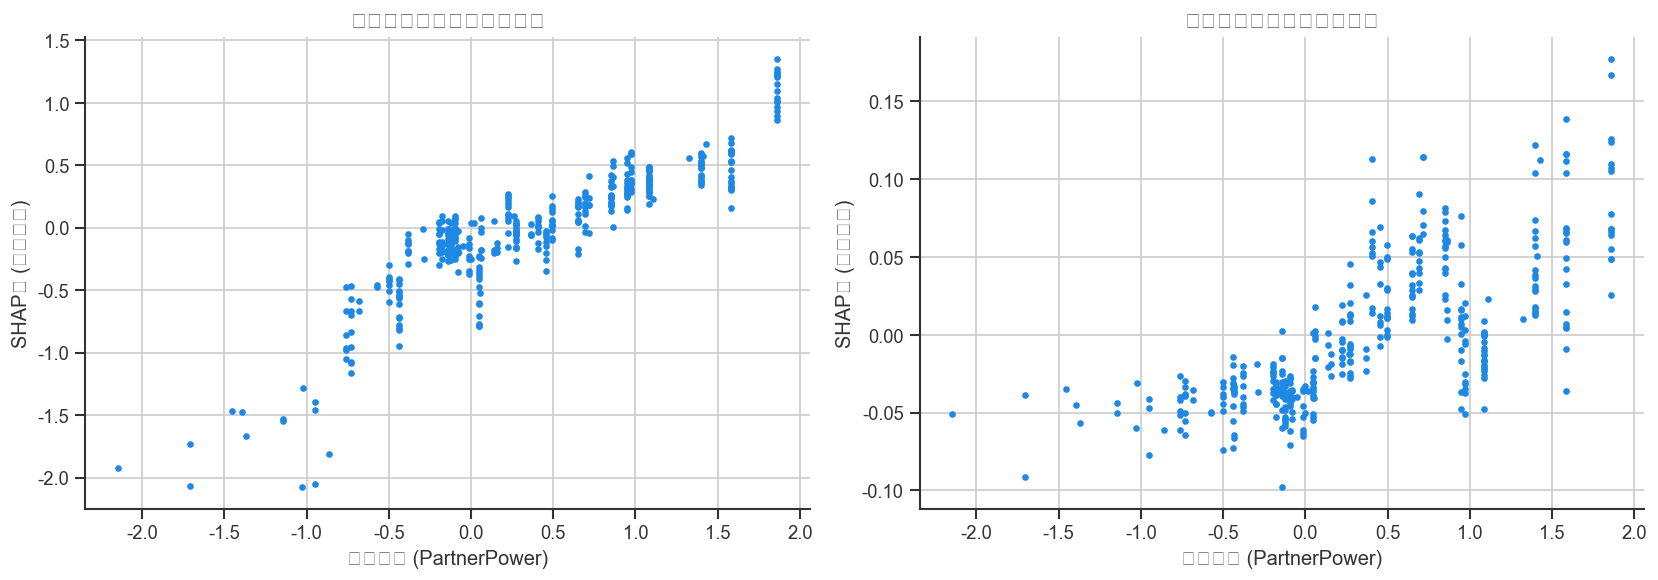

✓ 图表已保存: figs/问题4_舞伴实力效应分析.png


In [43]:
# Cell 13: SHAP Dependence Plot - 舞伴实力的边际贡献

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 舞伴实力 vs 评委得分
shap.dependence_plot(
    'PartnerPower', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('舞伴实力 (PartnerPower)', fontsize=12)
axes[0].set_ylabel('SHAP值 (评委得分)', fontsize=12)
axes[0].set_title('舞伴实力对评委得分的影响', fontsize=13, fontweight='bold')

# 舞伴实力 vs 粉丝投票
shap.dependence_plot(
    'PartnerPower', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('舞伴实力 (PartnerPower)', fontsize=12)
axes[1].set_ylabel('SHAP值 (粉丝投票)', fontsize=12)
axes[1].set_title('舞伴实力对粉丝投票的影响', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_舞伴实力效应分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_舞伴实力效应分析.png')

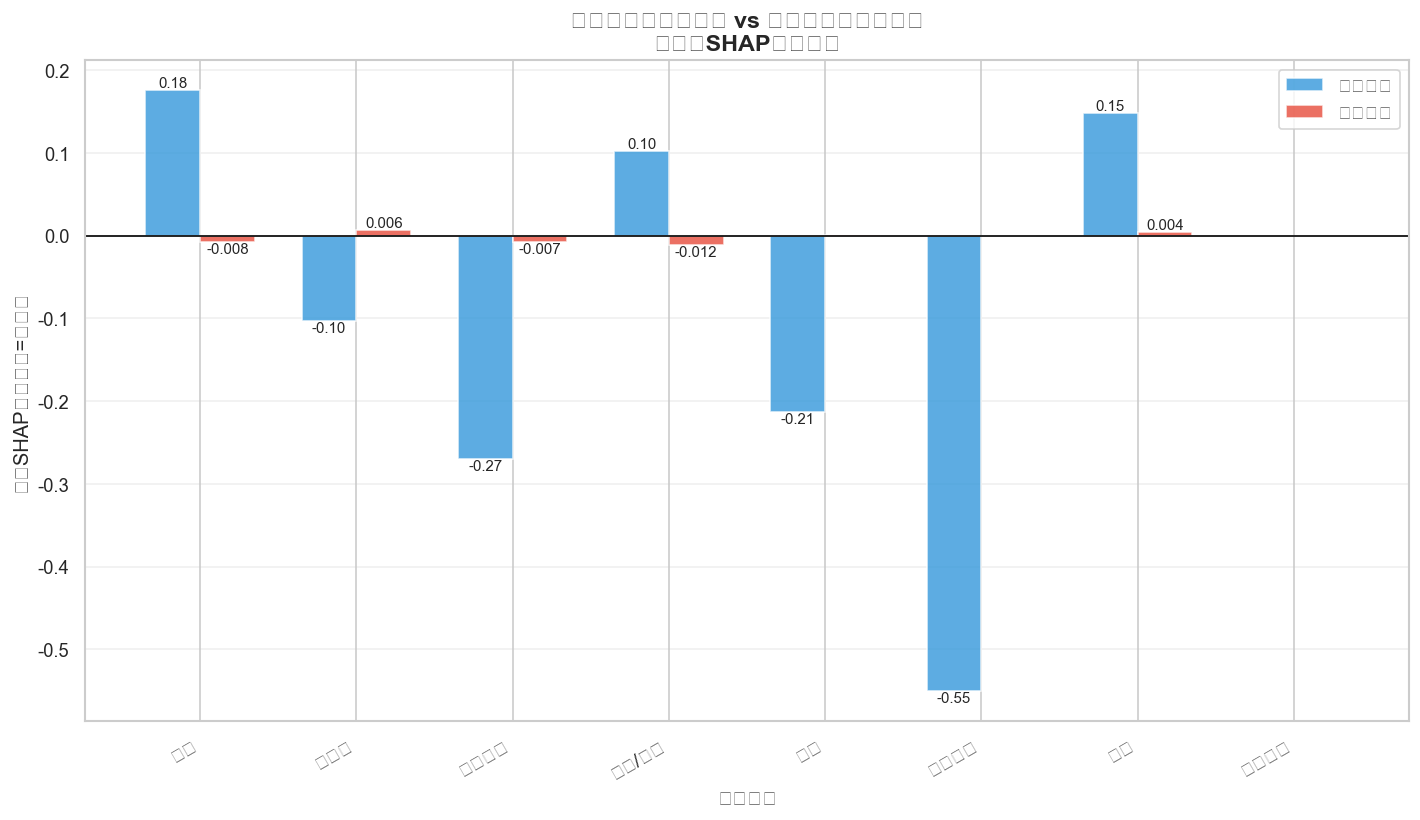

✓ 图表已保存: figs/问题4_行业类型SHAP效应对比.png


In [44]:
# Cell 14: 行业类型的SHAP效应对比

# 提取行业特征的SHAP值
industry_cols = ['is_Actor_Actress', 'is_Athlete', 'is_TV_Personality', 
                 'is_Singer_Rapper', 'is_Model', 'is_Comedian',
                 'is_Social_Media_Personality', 'is_Radio_Personality']
industry_names = ['演员', '运动员', '电视名人', '歌手/说唱', '模特', '喜剧演员', '网红', '电台主持']

industry_idx = [feature_cols.index(c) for c in industry_cols]

# 计算每个行业特征的平均SHAP值（正向=该行业有利）
# 注意：只看该行业选手的SHAP值均值
industry_effects_judge = []
industry_effects_fan = []

for i, col in enumerate(industry_cols):
    mask = X[col] == 1
    idx = feature_cols.index(col)
    if mask.sum() > 0:
        industry_effects_judge.append(shap_values_judge[mask, idx].mean())
        industry_effects_fan.append(shap_values_fan[mask, idx].mean())
    else:
        industry_effects_judge.append(0)
        industry_effects_fan.append(0)

# 可视化
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(industry_names))
width = 0.35

bars1 = ax.bar(x - width/2, industry_effects_judge, width, label='评委得分', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, industry_effects_fan, width, label='粉丝投票', color='#e74c3c', alpha=0.8)

ax.axhline(y=0, color='black', linewidth=1)
ax.set_ylabel('平均SHAP值（正值=有利）', fontsize=12)
ax.set_xlabel('行业类型', fontsize=12)
ax.set_title('不同行业对评委得分 vs 粉丝投票的影响差异\n（基于SHAP值分析）', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(industry_names, rotation=30, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, val in zip(bars1, industry_effects_judge):
    if abs(val) > 0.05:
        ax.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

for bar, val in zip(bars2, industry_effects_fan):
    if abs(val) > 0.002:
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('figs/问题4_行业类型SHAP效应对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_行业类型SHAP效应对比.png')

## 5. 特征交互效应分析

正在计算SHAP交互效应（可能需要几分钟）...
计算完成！


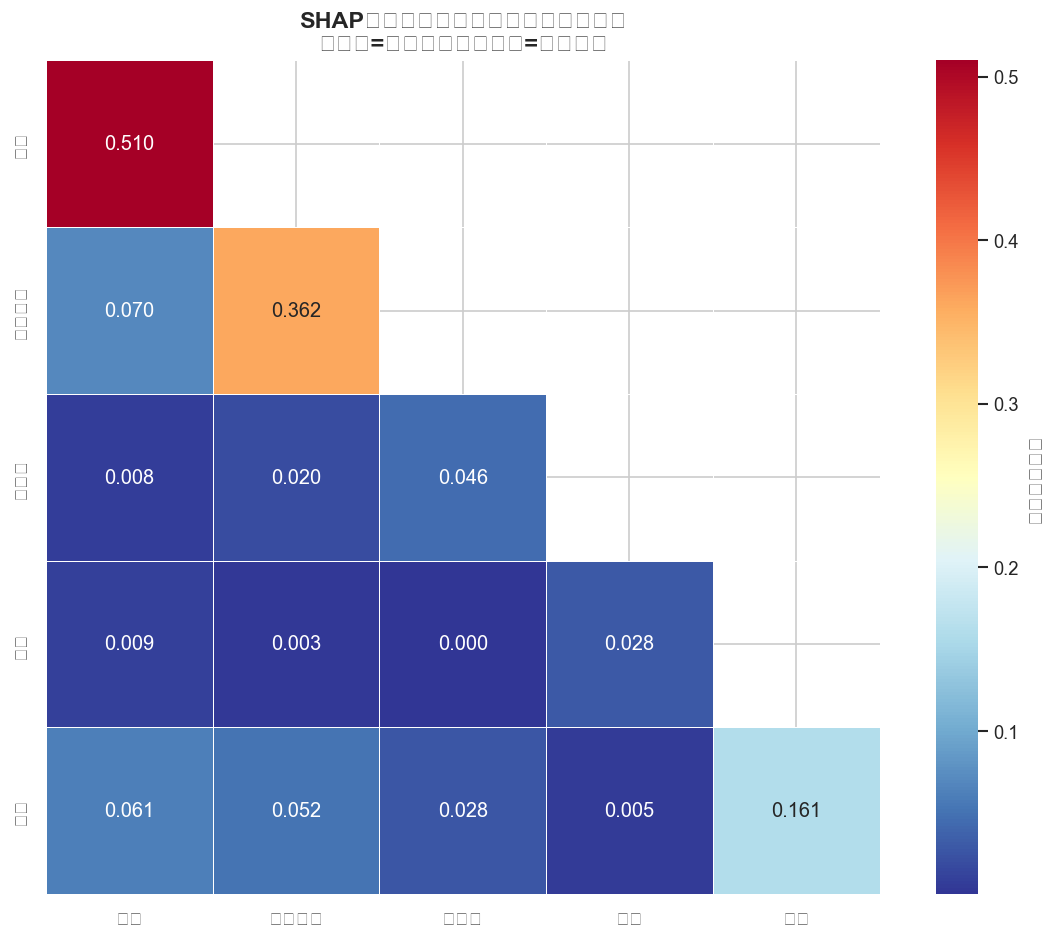

✓ 图表已保存: figs/问题4_SHAP交互效应热力图.png


In [45]:
# Cell 15: SHAP交互效应热力图

# 计算交互效应（使用TreeExplainer）
print('正在计算SHAP交互效应（可能需要几分钟）...')
shap_interaction_judge = explainer_judge.shap_interaction_values(X)
print('计算完成！')

# 提取主要特征的交互效应
main_features = ['celebrity_age', 'PartnerPower', 'is_Athlete', 'is_Singer_Rapper', 'season']
main_idx = [feature_cols.index(f) for f in main_features]
main_names = ['年龄', '舞伴实力', '运动员', '歌手', '赛季']

# 计算平均交互效应矩阵
interaction_matrix = np.abs(shap_interaction_judge[:, main_idx, :][:, :, main_idx]).mean(axis=0)

# 可视化
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)  # 只显示下三角

sns.heatmap(interaction_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdYlBu_r',
            xticklabels=main_names, yticklabels=main_names,
            linewidths=0.5, square=True, ax=ax,
            cbar_kws={'label': '交互效应强度'})

ax.set_title('SHAP交互效应热力图（评委得分模型）\n对角线=主效应，非对角线=交互效应', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_SHAP交互效应热力图.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP交互效应热力图.png')

## 6. 个体选手归因分析（案例研究）

In [46]:
# Cell 16: 选择典型选手进行个体归因分析

# 选择几个有代表性的选手
# 1. 高评委分低粉丝投票的选手
# 2. 低评委分高粉丝投票的选手

df_model_sorted = df_model.copy()
df_model_sorted['judge_rank'] = df_model_sorted['season_avg_score'].rank(ascending=False)
df_model_sorted['fan_rank'] = df_model_sorted['fan_vote_estimate'].rank(ascending=False)
df_model_sorted['rank_diff'] = df_model_sorted['fan_rank'] - df_model_sorted['judge_rank']

# 找出法官偏爱（高评委分低粉丝票）
judge_favorites = df_model_sorted.nlargest(5, 'rank_diff')[['celebrity_name', 'season', 'season_avg_score', 'fan_vote_estimate', 'rank_diff']]
print('='*70)
print('法官偏爱型选手（评委分高但粉丝投票低）')
print('='*70)
print(judge_favorites.to_string(index=False))

# 找出粉丝偏爱（低评委分高粉丝票）
fan_favorites = df_model_sorted.nsmallest(5, 'rank_diff')[['celebrity_name', 'season', 'season_avg_score', 'fan_vote_estimate', 'rank_diff']]
print('\n' + '='*70)
print('粉丝偏爱型选手（粉丝投票高但评委分低）')
print('='*70)
print(fan_favorites.to_string(index=False))

法官偏爱型选手（评委分高但粉丝投票低）
    celebrity_name  season  season_avg_score  fan_vote_estimate  rank_diff
           Tinashe      27          8.500000           0.008948      263.5
     Sabrina Bryan       5          9.000000           0.015337      260.0
  Christina Milian      17          8.333333           0.011620      224.0
Juan Pablo Di Pace      27          9.125000           0.023314      200.0
    Heather Morris      24          8.208333           0.013643      183.0

粉丝偏爱型选手（粉丝投票高但评委分低）
   celebrity_name  season  season_avg_score  fan_vote_estimate  rank_diff
Evander Holyfield       1          5.000000           0.040091     -221.0
    Clyde Drexler       4          5.200000           0.034137     -198.0
  Cloris Leachman       7          5.833333           0.039115     -185.5
          Steve-O       8          5.277778           0.030258     -185.0
      Bobby Bones      27          7.462963           0.537115     -181.0



分析选手: Tinashe
评委得分: 8.50
粉丝投票: 0.0089


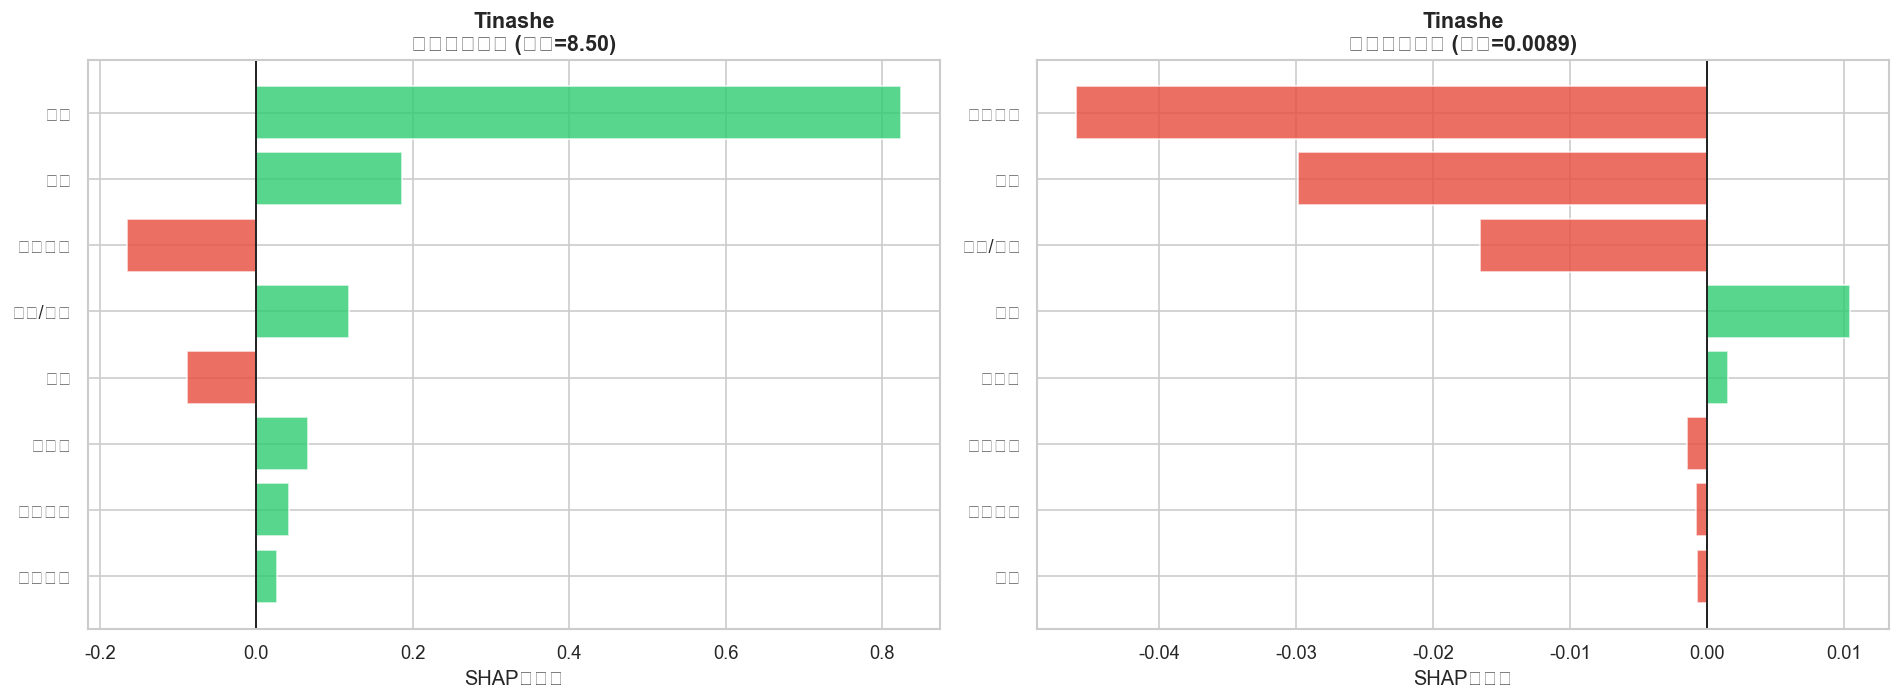

✓ 图表已保存: figs/问题4_个体归因案例分析.png


In [47]:
# Cell 17: SHAP Force Plot - 个体归因可视化

# 选择一个典型的"法官偏爱"选手进行分析
sample_name = judge_favorites.iloc[0]['celebrity_name']
sample_idx = df_model[df_model['celebrity_name'] == sample_name].index[0]
sample_idx_in_X = list(df_model.index).index(sample_idx)

print(f'\n分析选手: {sample_name}')
print(f'评委得分: {df_model.loc[sample_idx, "season_avg_score"]:.2f}')
print(f'粉丝投票: {df_model.loc[sample_idx, "fan_vote_estimate"]:.4f}')

# 使用waterfall图展示
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 评委得分的归因
ax1 = axes[0]
shap_vals_judge_sample = shap_values_judge[sample_idx_in_X]
sorted_idx = np.argsort(np.abs(shap_vals_judge_sample))[::-1][:8]  # Top 8特征

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals_judge_sample[sorted_idx]]
ax1.barh(range(len(sorted_idx)), shap_vals_judge_sample[sorted_idx], color=colors, alpha=0.8)
ax1.set_yticks(range(len(sorted_idx)))
ax1.set_yticklabels([feature_names[i] for i in sorted_idx])
ax1.invert_yaxis()
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('SHAP值贡献', fontsize=12)
ax1.set_title(f'{sample_name}\n评委得分归因 (实际={df_model.loc[sample_idx, "season_avg_score"]:.2f})', 
              fontsize=13, fontweight='bold')

# 粉丝投票的归因
ax2 = axes[1]
shap_vals_fan_sample = shap_values_fan[sample_idx_in_X]
sorted_idx_fan = np.argsort(np.abs(shap_vals_fan_sample))[::-1][:8]

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals_fan_sample[sorted_idx_fan]]
ax2.barh(range(len(sorted_idx_fan)), shap_vals_fan_sample[sorted_idx_fan], color=colors, alpha=0.8)
ax2.set_yticks(range(len(sorted_idx_fan)))
ax2.set_yticklabels([feature_names[i] for i in sorted_idx_fan])
ax2.invert_yaxis()
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('SHAP值贡献', fontsize=12)
ax2.set_title(f'{sample_name}\n粉丝投票归因 (实际={df_model.loc[sample_idx, "fan_vote_estimate"]:.4f})', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_个体归因案例分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_个体归因案例分析.png')

## 7. 综合结论与可视化

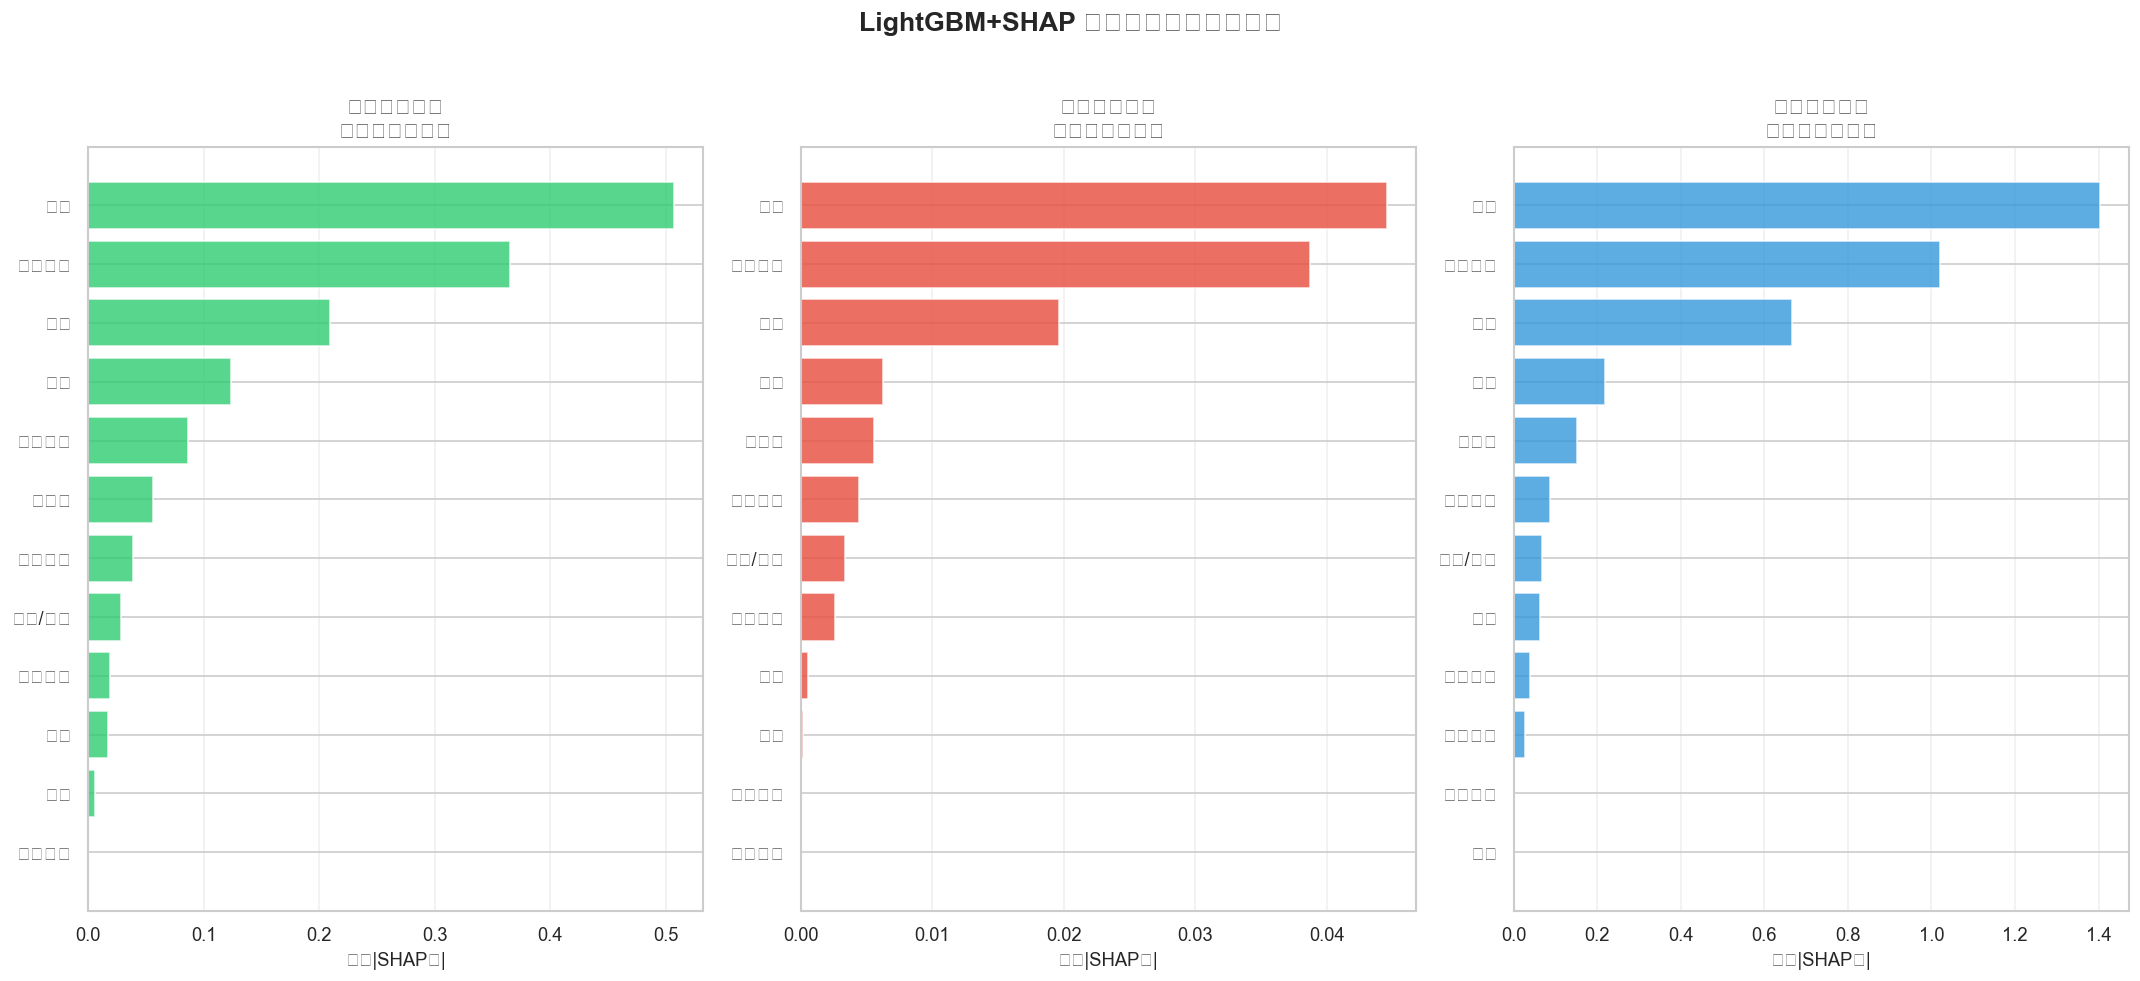

✓ 图表已保存: figs/问题4_三模型SHAP综合对比.png


In [48]:
# Cell 18: 综合对比图 - 三模型SHAP Summary

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 使用bar plot展示三个模型的特征重要性
for ax, (shap_vals, title, color) in zip(axes, [
    (shap_values_judge, '评委得分', '#2ecc71'),
    (shap_values_fan, '粉丝投票', '#e74c3c'),
    (shap_values_rank, '最终排名', '#3498db')
]):
    importance = np.abs(shap_vals).mean(axis=0)
    sorted_idx = np.argsort(importance)[::-1]
    
    ax.barh(range(len(feature_names)), importance[sorted_idx], color=color, alpha=0.8)
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.invert_yaxis()
    ax.set_xlabel('平均|SHAP值|', fontsize=11)
    ax.set_title(f'{title}模型\n特征重要性排序', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('LightGBM+SHAP 特征影响分析综合对比', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figs/问题4_三模型SHAP综合对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_三模型SHAP综合对比.png')

In [49]:
# Cell 19: 保存分析结果

# 保存特征重要性表
importance_df.to_csv('results/问题4_特征重要性_SHAP.csv', index=False, encoding='utf-8-sig')
print('✓ 特征重要性表已保存: results/问题4_特征重要性_SHAP.csv')

# 保存模型性能汇总
model_performance = pd.DataFrame({
    '模型': ['评委得分', '粉丝投票', '最终排名'],
    '测试集R²': [
        r2_score(y_judge_test, y_judge_pred),
        r2_score(y_fan_test, y_fan_pred),
        r2_score(y_rank_test, y_rank_pred)
    ],
    '测试集RMSE': [
        np.sqrt(mean_squared_error(y_judge_test, y_judge_pred)),
        np.sqrt(mean_squared_error(y_fan_test, y_fan_pred)),
        np.sqrt(mean_squared_error(y_rank_test, y_rank_pred))
    ],
    'CV_R²均值': [
        cv_scores_judge.mean(),
        cv_scores_fan.mean(),
        -cv_scores_rank.mean()  # 注意：排名模型使用neg_mse
    ]
})
model_performance.to_csv('results/问题4_模型性能汇总.csv', index=False, encoding='utf-8-sig')
print('✓ 模型性能汇总已保存: results/问题4_模型性能汇总.csv')

print('\n' + '='*70)
print('模型性能汇总')
print('='*70)
print(model_performance.to_string(index=False))

✓ 特征重要性表已保存: results/问题4_特征重要性_SHAP.csv
✓ 模型性能汇总已保存: results/问题4_模型性能汇总.csv

模型性能汇总
  模型     测试集R²  测试集RMSE   CV_R²均值
评委得分  0.230926 1.169164  0.176905
粉丝投票 -0.136837 0.202516 -0.148585
最终排名 -0.015273 3.594469 17.869683


In [50]:
# Cell 20: 核心发现总结

print('='*70)
print('问题四核心发现：LightGBM+SHAP特征影响分析')
print('='*70)

# 找出法官最看重的特征
top3_judge = importance_df.nlargest(3, '评委得分_归一化')['特征'].tolist()
print(f'\n【法官最看重的特征】')
for i, f in enumerate(top3_judge, 1):
    print(f'  {i}. {f}')

# 找出粉丝最看重的特征
top3_fan = importance_df.nlargest(3, '粉丝投票_归一化')['特征'].tolist()
print(f'\n【粉丝最看重的特征】')
for i, f in enumerate(top3_fan, 1):
    print(f'  {i}. {f}')

# 最大偏好差异
max_diff_row = importance_df.loc[importance_df['偏好差异'].abs().idxmax()]
print(f'\n【最大偏好差异】')
print(f'  特征: {max_diff_row["特征"]}')
print(f'  差异: {max_diff_row["偏好差异"]:+.2%}')
if max_diff_row['偏好差异'] > 0:
    print(f'  解读: 法官更看重此特征')
else:
    print(f'  解读: 粉丝更看重此特征')

print('\n' + '='*70)
print('分析完成！所有图表和结果已保存到 figs/ 和 results/ 目录')
print('='*70)

问题四核心发现：LightGBM+SHAP特征影响分析

【法官最看重的特征】
  1. 年龄
  2. 舞伴实力
  3. 赛季

【粉丝最看重的特征】
  1. 年龄
  2. 舞伴实力
  3. 赛季

【最大偏好差异】
  特征: 舞伴实力
  差异: -5.73%
  解读: 粉丝更看重此特征

分析完成！所有图表和结果已保存到 figs/ 和 results/ 目录


## 7. 英文标签图表重新生成 (解决中文显示问题)

In [51]:
# 重新定义英文特征名
feature_names_en = [
    'Age', 'International', 'Season',
    'Actor/Actress', 'Athlete', 'TV Personality', 'Singer/Rapper', 'Model', 'Comedian', 'Social Media', 'Radio Host',
    'Partner Power'
]

industry_names_en = ['Actor', 'Athlete', 'TV Personality', 'Singer/Rapper', 'Model', 'Comedian', 'Social Media', 'Radio Host']

# 设置英文字体
plt.rcParams['font.family'] = 'DejaVu Sans'
print("Feature names (EN):", feature_names_en)

Feature names (EN): ['Age', 'International', 'Season', 'Actor/Actress', 'Athlete', 'TV Personality', 'Singer/Rapper', 'Model', 'Comedian', 'Social Media', 'Radio Host', 'Partner Power']


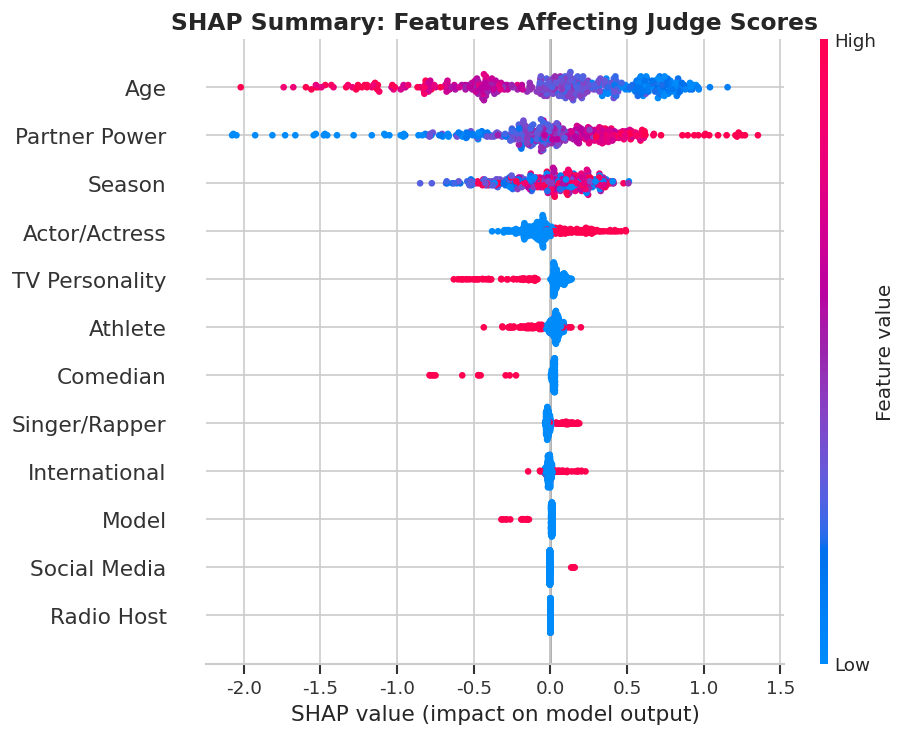

✓ Saved: figs/Q4_SHAP_JudgeScore_EN.png


In [52]:
# Figure 1: SHAP Summary Plot - Judge Score Model
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_judge, X, 
    feature_names=feature_names_en,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary: Features Affecting Judge Scores', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/Q4_SHAP_JudgeScore_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_SHAP_JudgeScore_EN.png')

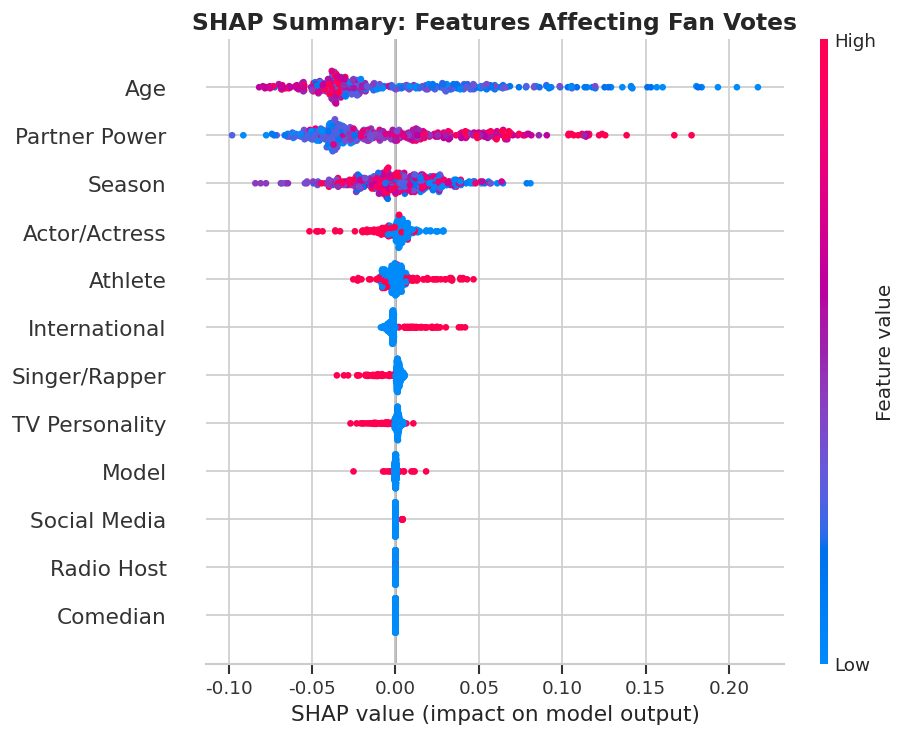

✓ Saved: figs/Q4_SHAP_FanVote_EN.png


In [53]:
# Figure 2: SHAP Summary Plot - Fan Vote Model
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_fan, X, 
    feature_names=feature_names_en,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary: Features Affecting Fan Votes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/Q4_SHAP_FanVote_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_SHAP_FanVote_EN.png')

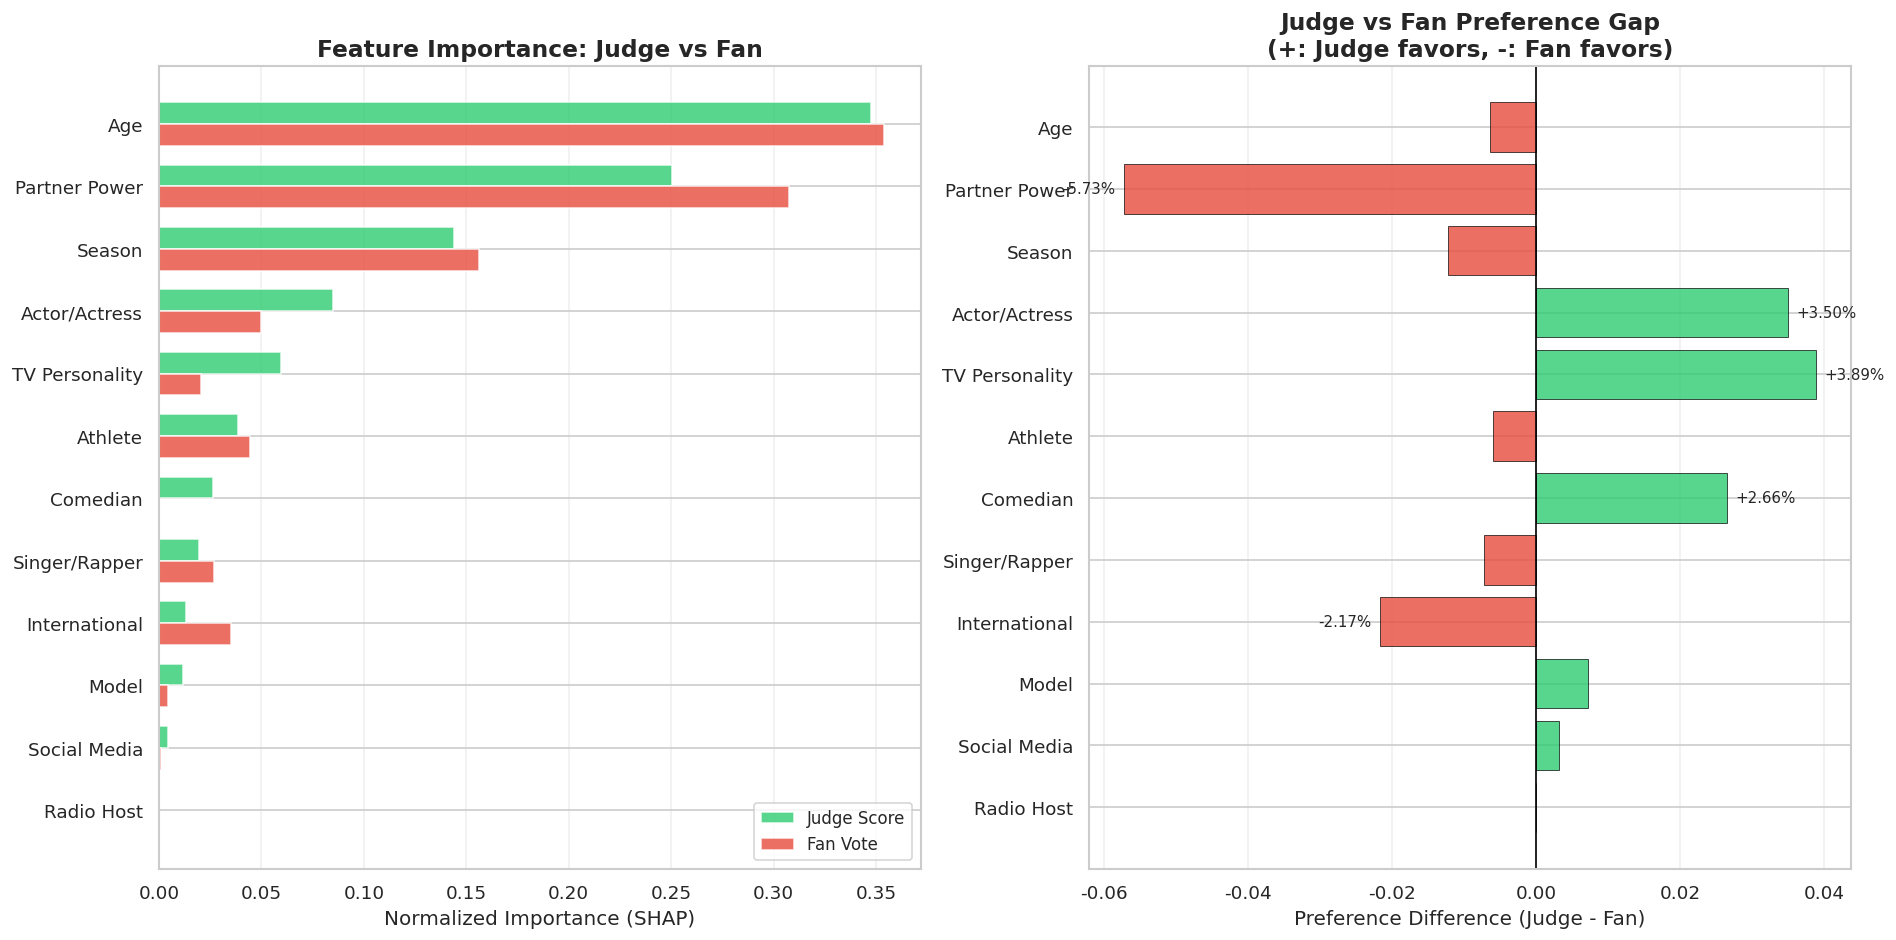

✓ Saved: figs/Q4_JudgeVsFan_Comparison_EN.png


In [54]:
# Figure 3: Judge vs Fan Feature Preference Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sorted_idx = np.argsort(importance_judge)[::-1]
sorted_features_en = [feature_names_en[i] for i in sorted_idx]

# Left: Feature Importance Comparison
ax1 = axes[0]
y_pos = np.arange(len(feature_names_en))
width = 0.35

bars1 = ax1.barh(y_pos - width/2, importance_judge_norm[sorted_idx], width, 
                  label='Judge Score', color='#2ecc71', alpha=0.8)
bars2 = ax1.barh(y_pos + width/2, importance_fan_norm[sorted_idx], width, 
                  label='Fan Vote', color='#e74c3c', alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_features_en)
ax1.invert_yaxis()
ax1.set_xlabel('Normalized Importance (SHAP)', fontsize=12)
ax1.set_title('Feature Importance: Judge vs Fan', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# Right: Preference Difference
ax2 = axes[1]
diff = importance_df.set_index('特征')['偏好差异'].reindex([feature_names[i] for i in sorted_idx]).values
colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in diff]

ax2.barh(y_pos, diff, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_features_en)
ax2.invert_yaxis()
ax2.set_xlabel('Preference Difference (Judge - Fan)', fontsize=12)
ax2.set_title('Judge vs Fan Preference Gap\n(+: Judge favors, -: Fan favors)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (d, f) in enumerate(zip(diff, sorted_features_en)):
    if abs(d) > 0.02:
        ax2.annotate(f'{d:+.2%}', xy=(d, i), 
                     xytext=(5 if d > 0 else -5, 0),
                     textcoords='offset points',
                     ha='left' if d > 0 else 'right',
                     va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figs/Q4_JudgeVsFan_Comparison_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_JudgeVsFan_Comparison_EN.png')

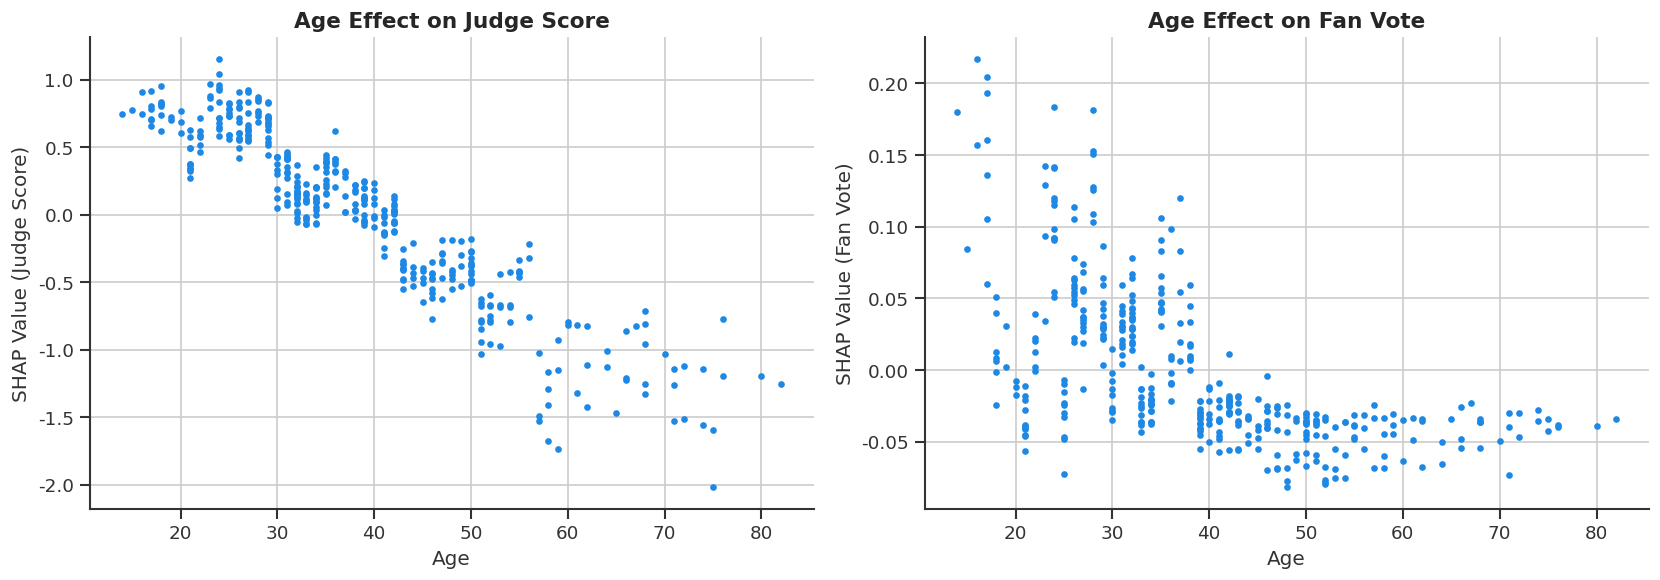

✓ Saved: figs/Q4_AgeEffect_EN.png


In [55]:
# Figure 4: Age Effect Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

shap.dependence_plot(
    'celebrity_age', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('SHAP Value (Judge Score)', fontsize=12)
axes[0].set_title('Age Effect on Judge Score', fontsize=13, fontweight='bold')

shap.dependence_plot(
    'celebrity_age', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('SHAP Value (Fan Vote)', fontsize=12)
axes[1].set_title('Age Effect on Fan Vote', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/Q4_AgeEffect_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_AgeEffect_EN.png')

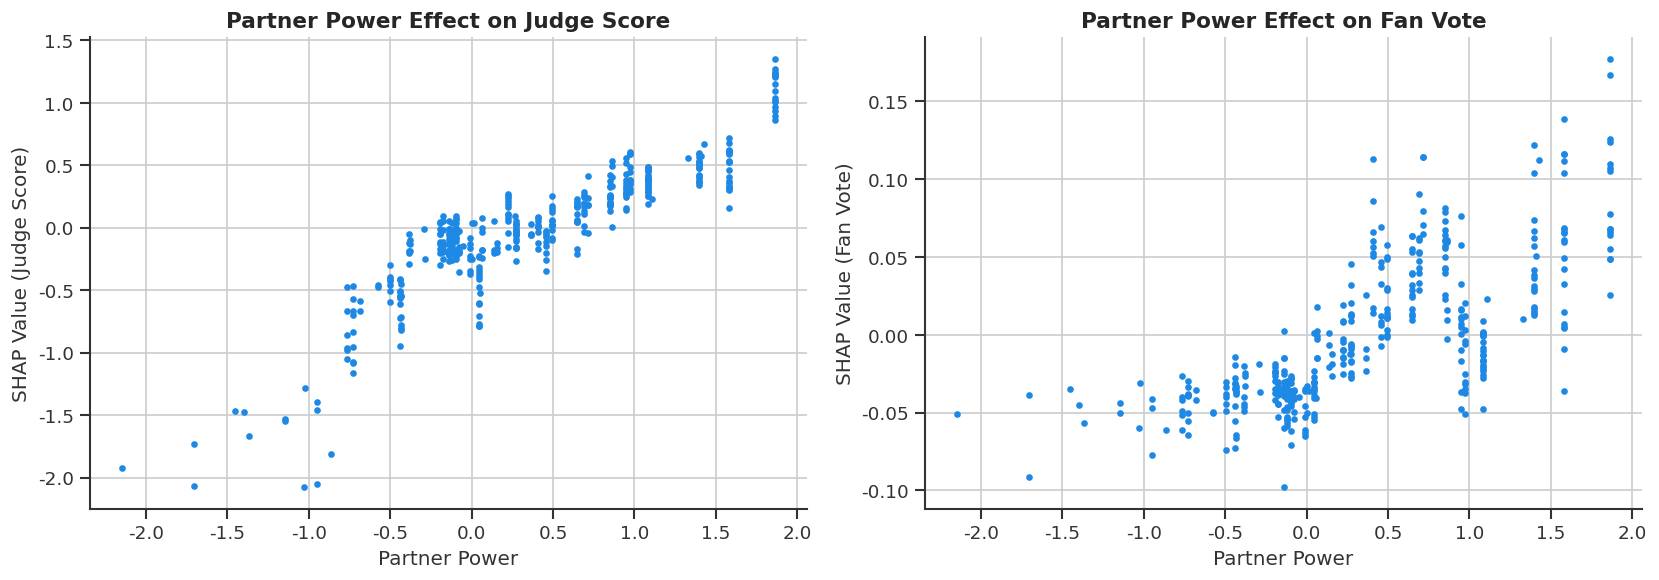

✓ Saved: figs/Q4_PartnerPower_EN.png


In [56]:
# Figure 5: Partner Power Effect Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

shap.dependence_plot(
    'PartnerPower', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('Partner Power', fontsize=12)
axes[0].set_ylabel('SHAP Value (Judge Score)', fontsize=12)
axes[0].set_title('Partner Power Effect on Judge Score', fontsize=13, fontweight='bold')

shap.dependence_plot(
    'PartnerPower', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('Partner Power', fontsize=12)
axes[1].set_ylabel('SHAP Value (Fan Vote)', fontsize=12)
axes[1].set_title('Partner Power Effect on Fan Vote', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/Q4_PartnerPower_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_PartnerPower_EN.png')

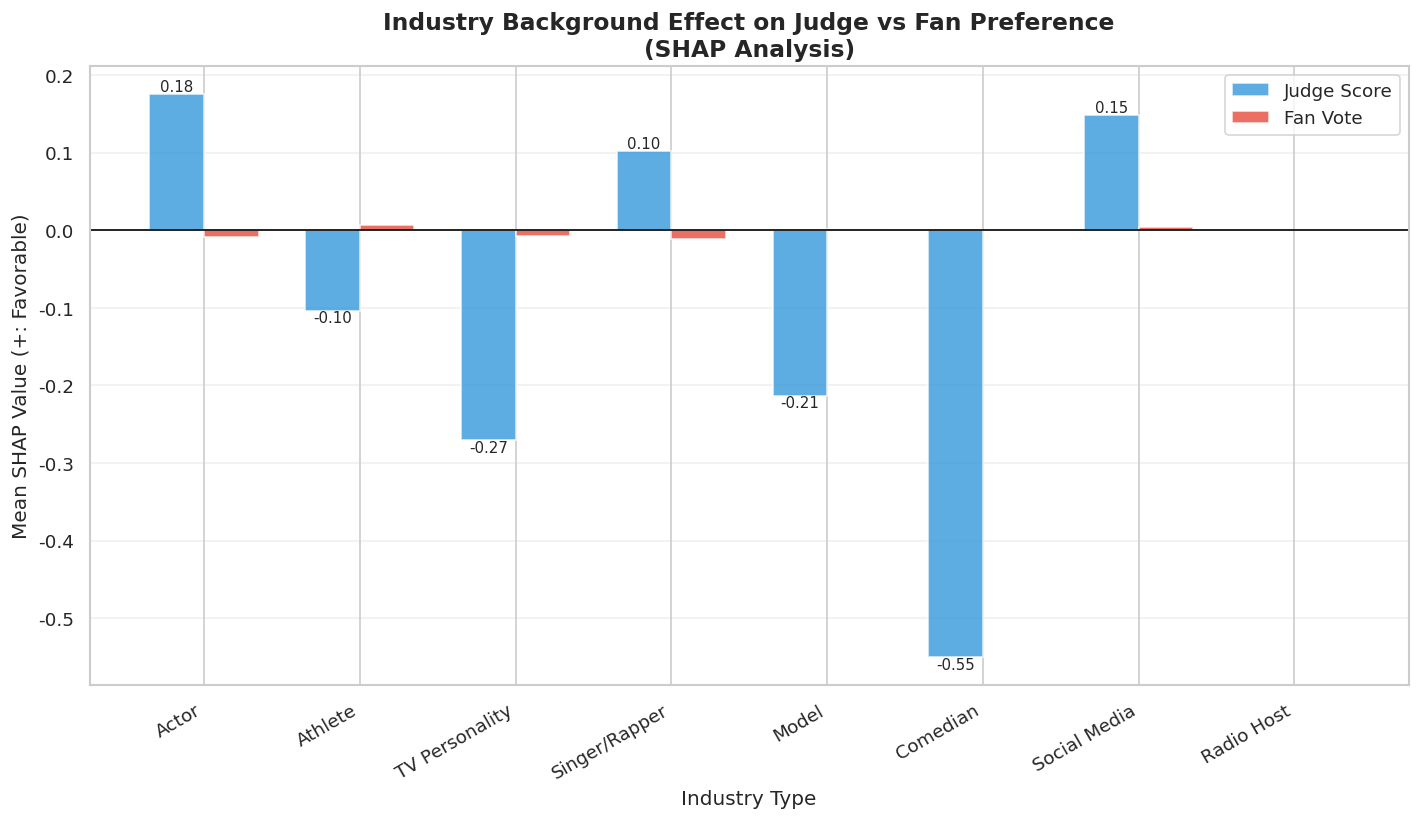

✓ Saved: figs/Q4_IndustryEffect_EN.png


In [57]:
# Figure 6: Industry Type Effect Comparison
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(industry_names_en))
width = 0.35

bars1 = ax.bar(x - width/2, industry_effects_judge, width, label='Judge Score', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, industry_effects_fan, width, label='Fan Vote', color='#e74c3c', alpha=0.8)

ax.axhline(y=0, color='black', linewidth=1)
ax.set_ylabel('Mean SHAP Value (+: Favorable)', fontsize=12)
ax.set_xlabel('Industry Type', fontsize=12)
ax.set_title('Industry Background Effect on Judge vs Fan Preference\n(SHAP Analysis)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(industry_names_en, rotation=30, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars1, industry_effects_judge):
    if abs(val) > 0.05:
        ax.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('figs/Q4_IndustryEffect_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_IndustryEffect_EN.png')

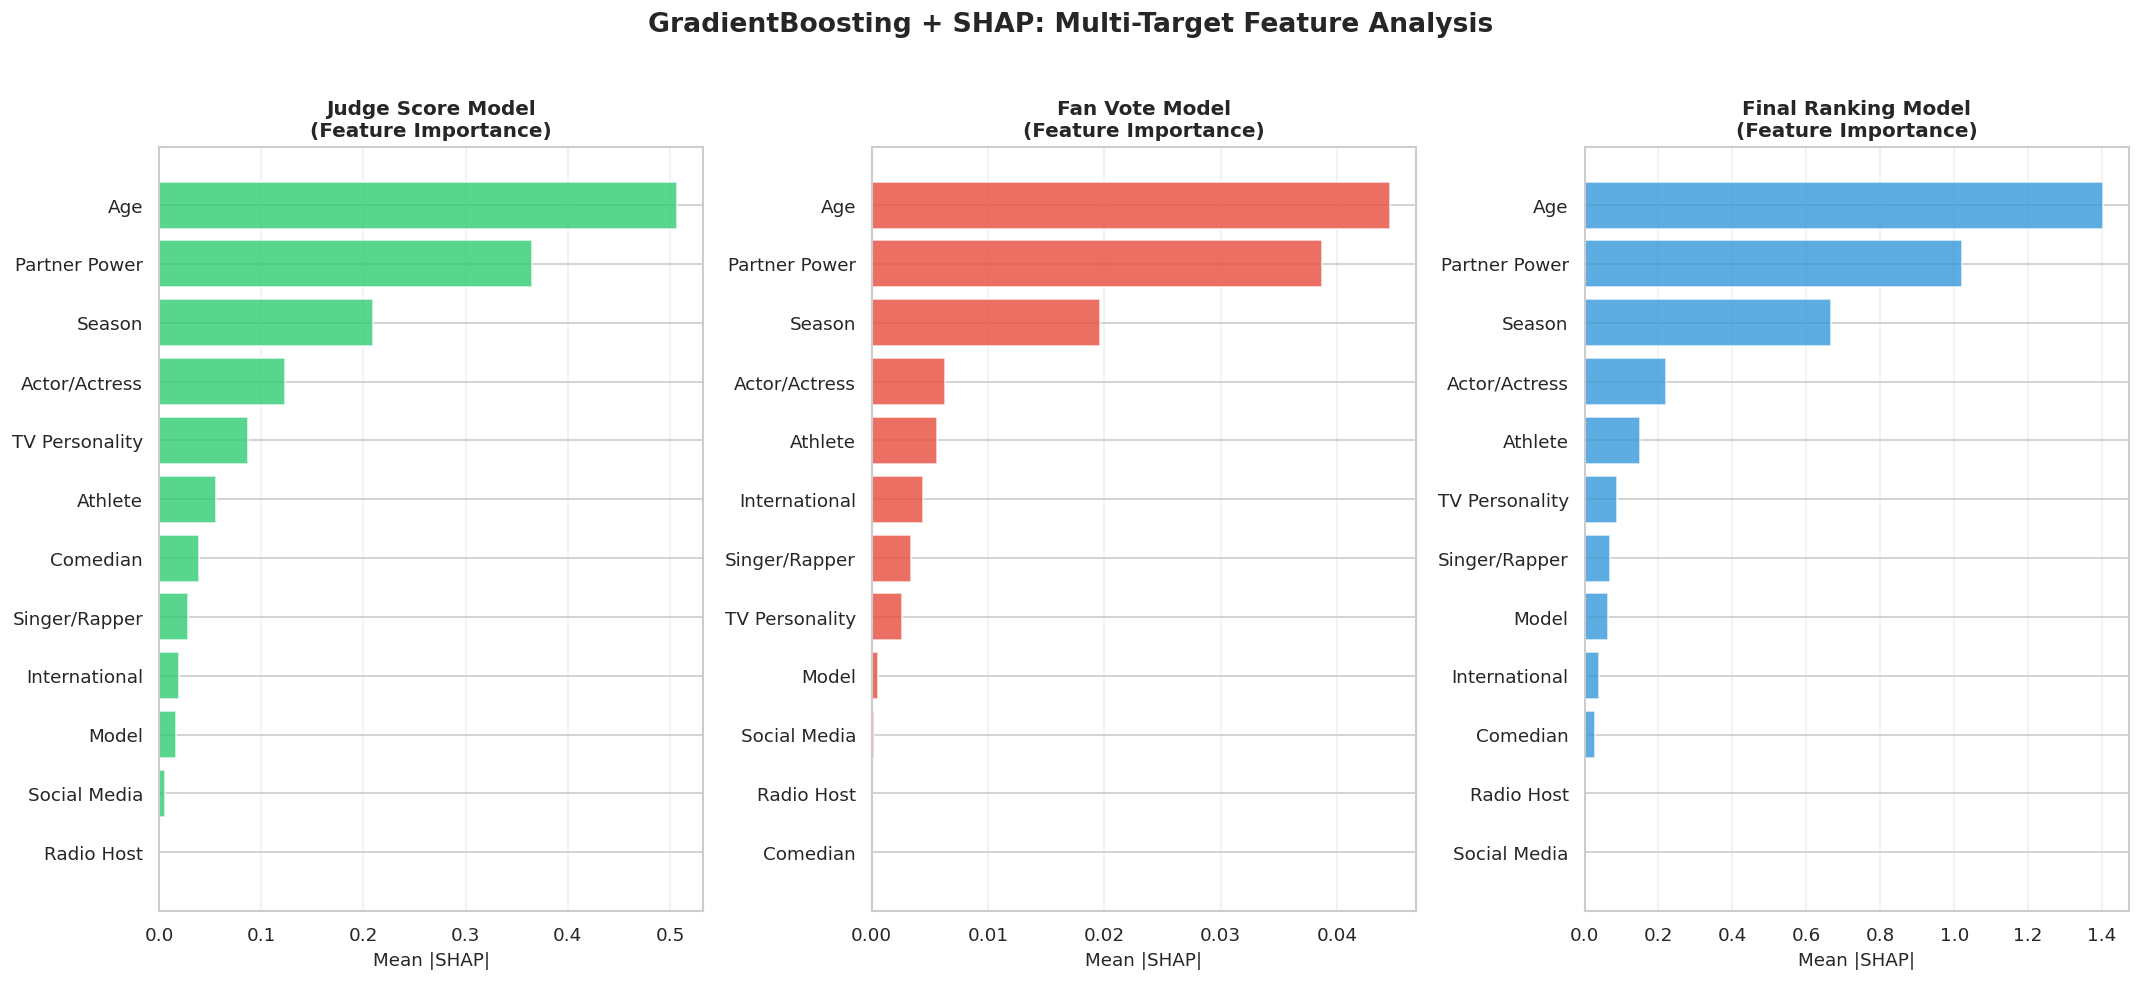

✓ Saved: figs/Q4_ThreeModel_Comparison_EN.png


In [58]:
# Figure 7: Three-Model Comparison (Global Feature Importance)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

models_data = [
    (importance_judge, 'Judge Score Model', '#2ecc71'),
    (importance_fan, 'Fan Vote Model', '#e74c3c'),
    (importance_rank, 'Final Ranking Model', '#3498db')
]

for ax, (importance, title, color) in zip(axes, models_data):
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features_en = [feature_names_en[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]
    
    ax.barh(range(len(sorted_features_en)), sorted_importance, color=color, alpha=0.8)
    ax.set_yticks(range(len(sorted_features_en)))
    ax.set_yticklabels(sorted_features_en)
    ax.invert_yaxis()
    ax.set_xlabel('Mean |SHAP|', fontsize=11)
    ax.set_title(f'{title}\n(Feature Importance)', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('GradientBoosting + SHAP: Multi-Target Feature Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figs/Q4_ThreeModel_Comparison_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_ThreeModel_Comparison_EN.png')

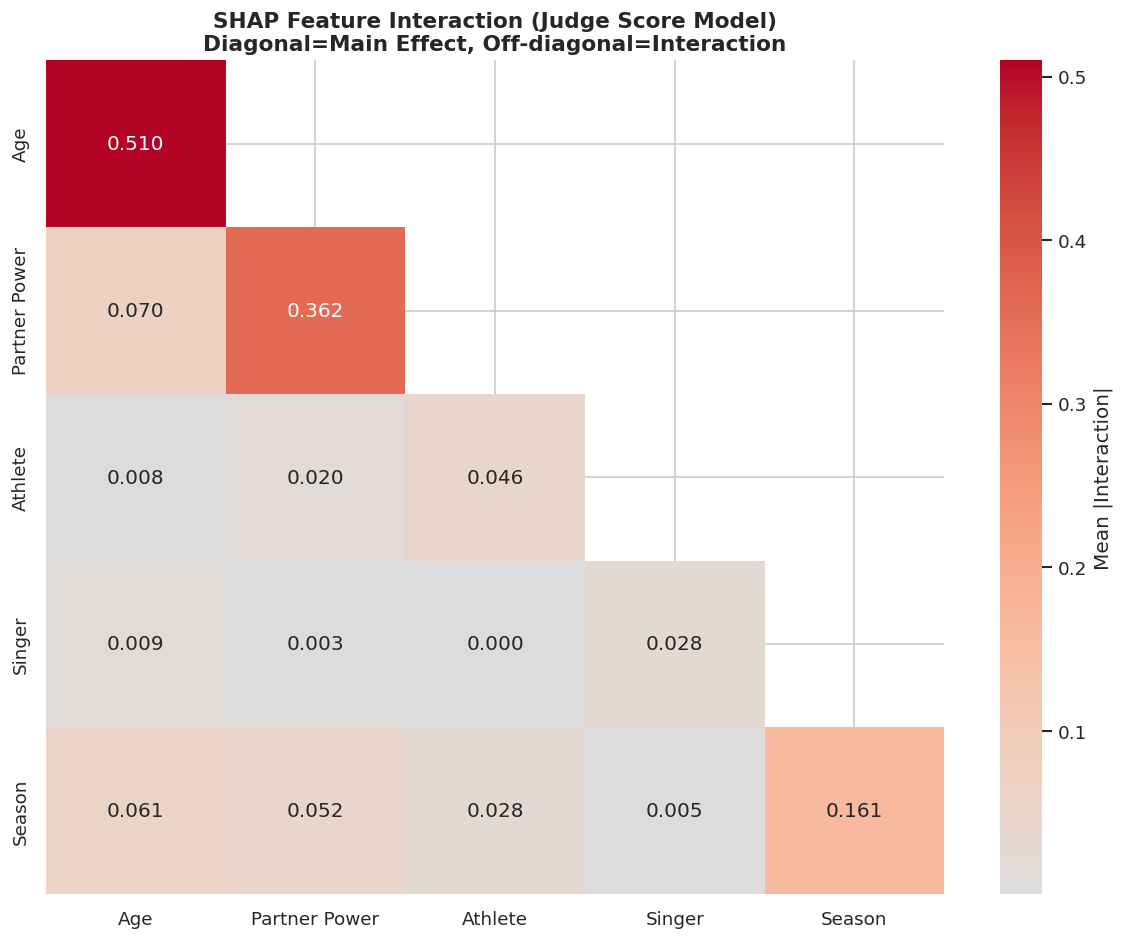

✓ Saved: figs/Q4_InteractionHeatmap_EN.png


In [59]:
# Figure 8: SHAP Interaction Heatmap
main_features_en = ['Age', 'Partner Power', 'Athlete', 'Singer', 'Season']

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)

sns.heatmap(interaction_matrix, mask=mask, annot=True, fmt='.3f',
            xticklabels=main_features_en, yticklabels=main_features_en,
            cmap='coolwarm', center=0, ax=ax,
            cbar_kws={'label': 'Mean |Interaction|'})

ax.set_title('SHAP Feature Interaction (Judge Score Model)\nDiagonal=Main Effect, Off-diagonal=Interaction', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/Q4_InteractionHeatmap_EN.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: figs/Q4_InteractionHeatmap_EN.png')

## 1. 数据加载与特征工程

In [60]:
# Cell 2: 加载选手汇总表
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题1_完整分析/问题1_选手汇总表.csv'
MAIN_DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'

df_summary = pd.read_csv(DATA_PATH)
df_main = pd.read_csv(MAIN_DATA_PATH)

print('='*70)
print('数据加载摘要')
print('='*70)
print(f'选手汇总表: {df_summary.shape[0]} 行 × {df_summary.shape[1]} 列')
print(f'有粉丝投票估计: {df_summary["fan_vote_estimate"].notna().sum()} 人')
print(f'决赛选手: {df_summary["is_finalist"].sum()} 人')
print(f'\n目标变量统计:')
print(f'  评委得分: [{df_summary["season_avg_score"].min():.2f}, {df_summary["season_avg_score"].max():.2f}]')
print(f'  粉丝投票: [{df_summary["fan_vote_estimate"].min():.4f}, {df_summary["fan_vote_estimate"].max():.4f}]')
print(f'  最终排名: [{df_summary["placement"].min()}, {df_summary["placement"].max()}]')

数据加载摘要
选手汇总表: 408 行 × 29 列
有粉丝投票估计: 395 人
决赛选手: 108 人

目标变量统计:
  评委得分: [3.50, 9.52]
  粉丝投票: [0.0040, 0.7473]
  最终排名: [1, 16]


In [61]:
# Cell 3: 特征工程 - 计算专业舞者影响力指标

def calculate_partner_power(df):
    """
    计算专业舞者影响力指标 PartnerPower
    = 0.4 × 标准化(历史平均得分) + 0.4 × 标准化(历史平均存活周数) + 0.2 × 标准化(决赛次数)
    """
    # 基础统计
    partner_stats = df.groupby('ballroom_partner').agg({
        'season_avg_score': 'mean',
        'weeks_survived': 'mean',
        'celebrity_name': 'count',
        'is_finalist': 'sum'
    }).reset_index()
    
    partner_stats.columns = ['ballroom_partner', 'partner_avg_score', 'partner_avg_weeks', 
                              'partner_total_celebs', 'partner_finalist_count']
    
    # 标准化后加权计算 PartnerPower
    scaler = StandardScaler()
    partner_stats['score_z'] = scaler.fit_transform(partner_stats[['partner_avg_score']])
    partner_stats['weeks_z'] = scaler.fit_transform(partner_stats[['partner_avg_weeks']])
    partner_stats['finalist_z'] = scaler.fit_transform(partner_stats[['partner_finalist_count']])
    
    # PartnerPower = 0.4*得分 + 0.4*存活周数 + 0.2*决赛次数
    partner_stats['PartnerPower'] = (0.4 * partner_stats['score_z'] + 
                                      0.4 * partner_stats['weeks_z'] + 
                                      0.2 * partner_stats['finalist_z'])
    
    return partner_stats[['ballroom_partner', 'partner_avg_score', 'partner_avg_weeks', 
                          'partner_finalist_count', 'PartnerPower']]

# 计算PartnerPower
partner_power = calculate_partner_power(df_summary)

# 合并到主数据
df = df_summary.merge(partner_power, on='ballroom_partner', how='left')

print('='*70)
print('专业舞者影响力排名 (Top 10)')
print('='*70)
top_partners = partner_power.nlargest(10, 'PartnerPower')
for i, row in top_partners.iterrows():
    print(f'  {row["ballroom_partner"]}: PartnerPower={row["PartnerPower"]:.3f} '
          f'(得分{row["partner_avg_score"]:.2f}, 周数{row["partner_avg_weeks"]:.1f}, 决赛{int(row["partner_finalist_count"])}次)')

专业舞者影响力排名 (Top 10)
  Derek Hough: PartnerPower=1.861 (得分8.85, 周数10.0, 决赛8次)
  Mark Ballas: PartnerPower=1.583 (得分8.36, 周数8.5, 决赛10次)
  Witney Carson (Xoshitl Gomez week 9): PartnerPower=1.428 (得分8.84, 周数11.0, 决赛1次)
  Val Chmerkovskiy (Joey Graziadei week 9): PartnerPower=1.409 (得分8.79, 周数11.0, 决赛1次)
  Valentin Chmerkovskiy: PartnerPower=1.399 (得分8.33, 周数8.5, 决赛8次)
  Ezra Sosa (Apolo Anton Ohno week 9): PartnerPower=1.326 (得分8.59, 周数11.0, 决赛1次)
  Charlotte Jorgensen: PartnerPower=1.108 (得分8.06, 周数11.0, 决赛1次)
  Cheryl Burke: PartnerPower=1.084 (得分7.59, 周数8.4, 决赛8次)
  Sasha Farber: PartnerPower=0.973 (得分8.13, 周数8.4, 决赛4次)
  Witney Carson: PartnerPower=0.948 (得分7.90, 周数7.8, 决赛6次)


In [62]:
# Cell 4: 准备建模数据集

# 选择特征列
feature_cols = [
    # 名人基础特征
    'celebrity_age',           # 年龄
    'is_international',        # 是否国际选手
    'season',                   # 赛季（时间效应）
    
    # 行业类型（One-Hot）
    'is_Actor_Actress',
    'is_Athlete',
    'is_TV_Personality',
    'is_Singer_Rapper',
    'is_Model',
    'is_Comedian',
    'is_Social_Media_Personality',
    'is_Radio_Personality',
    
    # 专业舞者特征
    'PartnerPower',            # 舞者综合实力
]

# 目标变量
target_judge = 'season_avg_score'     # 评委得分（回归）
target_fan = 'fan_vote_estimate'      # 粉丝投票（回归）
target_rank = 'placement'             # 最终排名（排序回归）

# 过滤有效数据（需要有粉丝投票估计）
df_model = df[df['fan_vote_estimate'].notna()].copy()

# 填充缺失的PartnerPower
df_model['PartnerPower'] = df_model['PartnerPower'].fillna(0)

# 提取特征矩阵和目标向量
X = df_model[feature_cols].copy()
y_judge = df_model[target_judge].values
y_fan = df_model[target_fan].values
y_rank = df_model[target_rank].values

# 特征名称（用于SHAP可视化）
feature_names = [
    '年龄', '国际选手', '赛季',
    '演员', '运动员', '电视名人', '歌手/说唱', '模特', '喜剧演员', '网红', '电台主持',
    '舞伴实力'
]

print('='*70)
print('建模数据集准备完成')
print('='*70)
print(f'样本数: {len(X)}')
print(f'特征数: {len(feature_cols)}')
print(f'\n特征列表:')
for i, (col, name) in enumerate(zip(feature_cols, feature_names)):
    print(f'  {i+1}. {col} → {name}')

print(f'\n目标变量统计:')
print(f'  评委得分: mean={y_judge.mean():.2f}, std={y_judge.std():.2f}')
print(f'  粉丝投票: mean={y_fan.mean():.4f}, std={y_fan.std():.4f}')
print(f'  最终排名: mean={y_rank.mean():.1f}, range=[{y_rank.min()}, {y_rank.max()}]')

建模数据集准备完成
样本数: 395
特征数: 12

特征列表:
  1. celebrity_age → 年龄
  2. is_international → 国际选手
  3. season → 赛季
  4. is_Actor_Actress → 演员
  5. is_Athlete → 运动员
  6. is_TV_Personality → 电视名人
  7. is_Singer_Rapper → 歌手/说唱
  8. is_Model → 模特
  9. is_Comedian → 喜剧演员
  10. is_Social_Media_Personality → 网红
  11. is_Radio_Personality → 电台主持
  12. PartnerPower → 舞伴实力

目标变量统计:
  评委得分: mean=7.39, std=1.32
  粉丝投票: mean=0.1004, std=0.1625
  最终排名: mean=6.7, range=[1, 16]


## 2. XGBoost模型训练

### 模型配置
- **正则化**：L1/L2正则 + max_depth限制防止过拟合
- **交叉验证**：5-Fold CV评估模型稳定性
- **目标函数**：
  - 回归任务：$\mathcal{L} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \Omega(f)$
  - 正则项：$\Omega(f) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$

In [63]:
# Cell 5: 定义XGBoost模型参数

# 通用参数（控制过拟合）
xgb_params = {
    'n_estimators': 100,
    'max_depth': 4,              # 限制树深度
    'learning_rate': 0.1,
    'min_child_weight': 5,       # 最小叶子样本数
    'subsample': 0.8,            # 行采样
    'colsample_bytree': 0.8,     # 列采样
    'reg_alpha': 0.1,            # L1正则
    'reg_lambda': 1.0,           # L2正则
    'random_state': 42,
    'n_jobs': -1
}

# 训练-测试集划分
X_train, X_test, y_judge_train, y_judge_test, y_fan_train, y_fan_test, y_rank_train, y_rank_test = \
    train_test_split(X, y_judge, y_fan, y_rank, test_size=0.2, random_state=42)

print(f'训练集: {len(X_train)} 样本')
print(f'测试集: {len(X_test)} 样本')
print(f'\nXGBoost参数:')
for k, v in xgb_params.items():
    print(f'  {k}: {v}')

训练集: 316 样本
测试集: 79 样本

XGBoost参数:
  n_estimators: 100
  max_depth: 4
  learning_rate: 0.1
  min_child_weight: 5
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 1.0
  random_state: 42
  n_jobs: -1


In [64]:
# Cell 6: 训练三个XGBoost模型

# ====== 模型1：评委得分预测 ======
model_judge = XGBRegressor(**xgb_params)
model_judge.fit(X_train, y_judge_train)
y_judge_pred = model_judge.predict(X_test)

# 5-Fold交叉验证
cv_scores_judge = cross_val_score(model_judge, X, y_judge, cv=5, scoring='r2')

print('='*70)
print('模型1: 评委得分预测 (XGBRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_judge_test, y_judge_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_judge_test, y_judge_pred)):.4f}')
print(f'  5-Fold CV R²: {cv_scores_judge.mean():.4f} ± {cv_scores_judge.std():.4f}')

# ====== 模型2：粉丝投票预测 ======
model_fan = XGBRegressor(**xgb_params)
model_fan.fit(X_train, y_fan_train)
y_fan_pred = model_fan.predict(X_test)

cv_scores_fan = cross_val_score(model_fan, X, y_fan, cv=5, scoring='r2')

print('\n' + '='*70)
print('模型2: 粉丝投票预测 (XGBRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_fan_test, y_fan_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_fan_test, y_fan_pred)):.6f}')
print(f'  5-Fold CV R²: {cv_scores_fan.mean():.4f} ± {cv_scores_fan.std():.4f}')

# ====== 模型3：最终排名预测 ======
# 对于排名，使用回归预测后转换
model_rank = XGBRegressor(**xgb_params)
model_rank.fit(X_train, y_rank_train)
y_rank_pred = model_rank.predict(X_test)

cv_scores_rank = cross_val_score(model_rank, X, y_rank, cv=5, scoring='neg_mean_squared_error')

print('\n' + '='*70)
print('模型3: 最终排名预测 (XGBRegressor)')
print('='*70)
print(f'  测试集R²: {r2_score(y_rank_test, y_rank_pred):.4f}')
print(f'  测试集RMSE: {np.sqrt(mean_squared_error(y_rank_test, y_rank_pred)):.2f}')
print(f'  5-Fold CV RMSE: {np.sqrt(-cv_scores_rank.mean()):.2f} ± {np.sqrt(cv_scores_rank.std()):.2f}')

NameError: name 'XGBRegressor' is not defined

## 3. SHAP值计算与可解释性分析

### SHAP核心概念
- **全局影响度**：$I_k = \frac{1}{n}\sum_{i=1}^{n}|\phi_k^{(i)}|$ （特征k的平均绝对贡献）
- **影响方向**：$\phi_k > 0$ 表示正向影响，$\phi_k < 0$ 表示负向影响
- **偏好差异**：$\Delta_k = I_k^{\text{judge}} - I_k^{\text{fan}}$ （法官vs粉丝的特征偏好差异）

In [ ]:
# Cell 7: 计算SHAP值

# 使用TreeExplainer（针对XGBoost优化）
explainer_judge = shap.TreeExplainer(model_judge)
explainer_fan = shap.TreeExplainer(model_fan)
explainer_rank = shap.TreeExplainer(model_rank)

# 计算全量数据的SHAP值
shap_values_judge = explainer_judge.shap_values(X)
shap_values_fan = explainer_fan.shap_values(X)
shap_values_rank = explainer_rank.shap_values(X)

print('='*70)
print('SHAP值计算完成')
print('='*70)
print(f'SHAP矩阵维度: {shap_values_judge.shape}')
print(f'  样本数: {shap_values_judge.shape[0]}')
print(f'  特征数: {shap_values_judge.shape[1]}')

In [ ]:
# Cell 8: 计算全局特征影响度

# 特征影响度 = 平均绝对SHAP值
importance_judge = np.abs(shap_values_judge).mean(axis=0)
importance_fan = np.abs(shap_values_fan).mean(axis=0)
importance_rank = np.abs(shap_values_rank).mean(axis=0)

# 标准化（便于比较）
def normalize(x):
    return x / x.sum()

importance_judge_norm = normalize(importance_judge)
importance_fan_norm = normalize(importance_fan)
importance_rank_norm = normalize(importance_rank)

# 汇总表
importance_df = pd.DataFrame({
    '特征': feature_names,
    '特征代码': feature_cols,
    '评委得分_SHAP': importance_judge,
    '粉丝投票_SHAP': importance_fan,
    '最终排名_SHAP': importance_rank,
    '评委得分_归一化': importance_judge_norm,
    '粉丝投票_归一化': importance_fan_norm,
    '最终排名_归一化': importance_rank_norm
})

# 计算法官vs粉丝的偏好差异
importance_df['偏好差异'] = importance_df['评委得分_归一化'] - importance_df['粉丝投票_归一化']
importance_df = importance_df.sort_values('评委得分_SHAP', ascending=False)

print('='*70)
print('全局特征影响度（SHAP）')
print('='*70)
print(importance_df[['特征', '评委得分_归一化', '粉丝投票_归一化', '偏好差异']].to_string(index=False))

In [ ]:
# Cell 9: SHAP Summary Plot - 评委得分模型

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_judge, X, 
    feature_names=feature_names,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary Plot: 评委得分影响因素', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/问题4_SHAP_评委得分.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP_评委得分.png')

In [ ]:
# Cell 10: SHAP Summary Plot - 粉丝投票模型

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_fan, X, 
    feature_names=feature_names,
    plot_type='dot',
    show=False,
    max_display=12
)
plt.title('SHAP Summary Plot: 粉丝投票影响因素', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/问题4_SHAP_粉丝投票.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP_粉丝投票.png')

In [ ]:
# Cell 11: 法官vs粉丝 特征影响度对比图

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 按评委得分影响度排序
sorted_idx = np.argsort(importance_judge)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]

# 左图：影响度对比条形图
ax1 = axes[0]
y_pos = np.arange(len(feature_names))
width = 0.35

bars1 = ax1.barh(y_pos - width/2, importance_judge_norm[sorted_idx], width, 
                  label='评委得分', color='#2ecc71', alpha=0.8)
bars2 = ax1.barh(y_pos + width/2, importance_fan_norm[sorted_idx], width, 
                  label='粉丝投票', color='#e74c3c', alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_features)
ax1.invert_yaxis()
ax1.set_xlabel('标准化影响度 (SHAP)', fontsize=12)
ax1.set_title('特征影响度对比：评委 vs 粉丝', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 右图：偏好差异图
ax2 = axes[1]
diff = importance_df.set_index('特征')['偏好差异'].reindex(sorted_features).values
colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in diff]

ax2.barh(y_pos, diff, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_features)
ax2.invert_yaxis()
ax2.set_xlabel('偏好差异 (评委 - 粉丝)', fontsize=12)
ax2.set_title('法官vs粉丝偏好差异\n(正值=法官更看重, 负值=粉丝更看重)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 添加标签
for i, (d, f) in enumerate(zip(diff, sorted_features)):
    if abs(d) > 0.02:
        ax2.annotate(f'{d:+.2%}', xy=(d, i), 
                     xytext=(5 if d > 0 else -5, 0),
                     textcoords='offset points',
                     ha='left' if d > 0 else 'right',
                     va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figs/问题4_法官vs粉丝_特征偏好对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_法官vs粉丝_特征偏好对比.png')

## 4. 关键特征深度分析

In [ ]:
# Cell 12: SHAP Dependence Plot - 年龄的非线性效应

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 年龄 vs 评委得分
shap.dependence_plot(
    'celebrity_age', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('年龄', fontsize=12)
axes[0].set_ylabel('SHAP值 (评委得分)', fontsize=12)
axes[0].set_title('年龄对评委得分的影响', fontsize=13, fontweight='bold')

# 年龄 vs 粉丝投票
shap.dependence_plot(
    'celebrity_age', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('年龄', fontsize=12)
axes[1].set_ylabel('SHAP值 (粉丝投票)', fontsize=12)
axes[1].set_title('年龄对粉丝投票的影响', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_年龄效应分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_年龄效应分析.png')

In [ ]:
# Cell 13: SHAP Dependence Plot - 舞伴实力的边际贡献

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 舞伴实力 vs 评委得分
shap.dependence_plot(
    'PartnerPower', shap_values_judge, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[0],
    show=False
)
axes[0].set_xlabel('舞伴实力 (PartnerPower)', fontsize=12)
axes[0].set_ylabel('SHAP值 (评委得分)', fontsize=12)
axes[0].set_title('舞伴实力对评委得分的影响', fontsize=13, fontweight='bold')

# 舞伴实力 vs 粉丝投票
shap.dependence_plot(
    'PartnerPower', shap_values_fan, X,
    feature_names=feature_cols,
    interaction_index=None,
    ax=axes[1],
    show=False
)
axes[1].set_xlabel('舞伴实力 (PartnerPower)', fontsize=12)
axes[1].set_ylabel('SHAP值 (粉丝投票)', fontsize=12)
axes[1].set_title('舞伴实力对粉丝投票的影响', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_舞伴实力效应分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_舞伴实力效应分析.png')

In [ ]:
# Cell 14: 行业类型的SHAP效应对比

# 提取行业特征的SHAP值
industry_cols = ['is_Actor_Actress', 'is_Athlete', 'is_TV_Personality', 
                 'is_Singer_Rapper', 'is_Model', 'is_Comedian',
                 'is_Social_Media_Personality', 'is_Radio_Personality']
industry_names = ['演员', '运动员', '电视名人', '歌手/说唱', '模特', '喜剧演员', '网红', '电台主持']

industry_idx = [feature_cols.index(c) for c in industry_cols]

# 计算每个行业特征的平均SHAP值（正向=该行业有利）
# 注意：只看该行业选手的SHAP值均值
industry_effects_judge = []
industry_effects_fan = []

for i, col in enumerate(industry_cols):
    mask = X[col] == 1
    idx = feature_cols.index(col)
    if mask.sum() > 0:
        industry_effects_judge.append(shap_values_judge[mask, idx].mean())
        industry_effects_fan.append(shap_values_fan[mask, idx].mean())
    else:
        industry_effects_judge.append(0)
        industry_effects_fan.append(0)

# 可视化
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(industry_names))
width = 0.35

bars1 = ax.bar(x - width/2, industry_effects_judge, width, label='评委得分', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, industry_effects_fan, width, label='粉丝投票', color='#e74c3c', alpha=0.8)

ax.axhline(y=0, color='black', linewidth=1)
ax.set_ylabel('平均SHAP值（正值=有利）', fontsize=12)
ax.set_xlabel('行业类型', fontsize=12)
ax.set_title('不同行业对评委得分 vs 粉丝投票的影响差异\n（基于SHAP值分析）', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(industry_names, rotation=30, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, val in zip(bars1, industry_effects_judge):
    if abs(val) > 0.05:
        ax.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

for bar, val in zip(bars2, industry_effects_fan):
    if abs(val) > 0.002:
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, val),
                    ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('figs/问题4_行业类型SHAP效应对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_行业类型SHAP效应对比.png')

## 5. 特征交互效应分析

In [ ]:
# Cell 15: SHAP交互效应热力图

# 计算交互效应（使用TreeExplainer）
# 注意：这需要较多计算时间
shap_interaction_judge = explainer_judge.shap_interaction_values(X)

# 提取主要特征的交互效应
main_features = ['celebrity_age', 'PartnerPower', 'is_Athlete', 'is_Singer_Rapper', 'season']
main_idx = [feature_cols.index(f) for f in main_features]
main_names = ['年龄', '舞伴实力', '运动员', '歌手', '赛季']

# 计算平均交互效应矩阵
interaction_matrix = np.abs(shap_interaction_judge[:, main_idx, :][:, :, main_idx]).mean(axis=0)

# 可视化
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)  # 只显示下三角

sns.heatmap(interaction_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdYlBu_r',
            xticklabels=main_names, yticklabels=main_names,
            linewidths=0.5, square=True, ax=ax,
            cbar_kws={'label': '交互效应强度'})

ax.set_title('SHAP交互效应热力图（评委得分模型）\n对角线=主效应，非对角线=交互效应', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_SHAP交互效应热力图.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_SHAP交互效应热力图.png')

## 6. 个体选手归因分析（案例研究）

In [ ]:
# Cell 16: 选择典型选手进行个体归因分析

# 选择几个有代表性的选手
# 1. 高评委分低粉丝投票的选手
# 2. 低评委分高粉丝投票的选手
# 3. 冠军选手

df_model_sorted = df_model.copy()
df_model_sorted['judge_rank'] = df_model_sorted['season_avg_score'].rank(ascending=False)
df_model_sorted['fan_rank'] = df_model_sorted['fan_vote_estimate'].rank(ascending=False)
df_model_sorted['rank_diff'] = df_model_sorted['fan_rank'] - df_model_sorted['judge_rank']

# 找出法官偏爱（高评委分低粉丝票）
judge_favorites = df_model_sorted.nlargest(5, 'rank_diff')[['celebrity_name', 'season', 'season_avg_score', 'fan_vote_estimate', 'rank_diff']]
print('='*70)
print('法官偏爱型选手（评委分高但粉丝投票低）')
print('='*70)
print(judge_favorites.to_string(index=False))

# 找出粉丝偏爱（低评委分高粉丝票）
fan_favorites = df_model_sorted.nsmallest(5, 'rank_diff')[['celebrity_name', 'season', 'season_avg_score', 'fan_vote_estimate', 'rank_diff']]
print('\n' + '='*70)
print('粉丝偏爱型选手（粉丝投票高但评委分低）')
print('='*70)
print(fan_favorites.to_string(index=False))

In [ ]:
# Cell 17: SHAP Force Plot - 个体归因可视化

# 选择一个典型的"法官偏爱"选手进行分析
sample_name = judge_favorites.iloc[0]['celebrity_name']
sample_idx = df_model[df_model['celebrity_name'] == sample_name].index[0]
sample_idx_in_X = list(df_model.index).index(sample_idx)

print(f'\n分析选手: {sample_name}')
print(f'评委得分: {df_model.loc[sample_idx, "season_avg_score"]:.2f}')
print(f'粉丝投票: {df_model.loc[sample_idx, "fan_vote_estimate"]:.4f}')

# 使用waterfall图展示
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 评委得分的归因
ax1 = axes[0]
shap_vals_judge_sample = shap_values_judge[sample_idx_in_X]
sorted_idx = np.argsort(np.abs(shap_vals_judge_sample))[::-1][:8]  # Top 8特征

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals_judge_sample[sorted_idx]]
ax1.barh(range(len(sorted_idx)), shap_vals_judge_sample[sorted_idx], color=colors, alpha=0.8)
ax1.set_yticks(range(len(sorted_idx)))
ax1.set_yticklabels([feature_names[i] for i in sorted_idx])
ax1.invert_yaxis()
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('SHAP值贡献', fontsize=12)
ax1.set_title(f'{sample_name}\n评委得分归因 (实际={df_model.loc[sample_idx, "season_avg_score"]:.2f})', 
              fontsize=13, fontweight='bold')

# 粉丝投票的归因
ax2 = axes[1]
shap_vals_fan_sample = shap_values_fan[sample_idx_in_X]
sorted_idx_fan = np.argsort(np.abs(shap_vals_fan_sample))[::-1][:8]

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals_fan_sample[sorted_idx_fan]]
ax2.barh(range(len(sorted_idx_fan)), shap_vals_fan_sample[sorted_idx_fan], color=colors, alpha=0.8)
ax2.set_yticks(range(len(sorted_idx_fan)))
ax2.set_yticklabels([feature_names[i] for i in sorted_idx_fan])
ax2.invert_yaxis()
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('SHAP值贡献', fontsize=12)
ax2.set_title(f'{sample_name}\n粉丝投票归因 (实际={df_model.loc[sample_idx, "fan_vote_estimate"]:.4f})', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题4_个体归因案例分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_个体归因案例分析.png')

## 7. 综合结论与可视化

In [ ]:
# Cell 18: 综合对比图 - 三模型SHAP Summary

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 使用bar plot展示三个模型的特征重要性
for ax, (shap_vals, title, color) in zip(axes, [
    (shap_values_judge, '评委得分', '#2ecc71'),
    (shap_values_fan, '粉丝投票', '#e74c3c'),
    (shap_values_rank, '最终排名', '#3498db')
]):
    importance = np.abs(shap_vals).mean(axis=0)
    sorted_idx = np.argsort(importance)[::-1]
    
    ax.barh(range(len(feature_names)), importance[sorted_idx], color=color, alpha=0.8)
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.invert_yaxis()
    ax.set_xlabel('平均|SHAP值|', fontsize=11)
    ax.set_title(f'{title}模型\n特征重要性排序', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('XGBoost+SHAP 特征影响分析综合对比', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figs/问题4_三模型SHAP综合对比.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_三模型SHAP综合对比.png')

In [ ]:
# Cell 19: 保存分析结果

# 保存特征重要性表
importance_df.to_csv('results/问题4_特征重要性_SHAP.csv', index=False, encoding='utf-8-sig')
print('✓ 特征重要性表已保存: results/问题4_特征重要性_SHAP.csv')

# 保存模型性能汇总
model_performance = pd.DataFrame({
    '模型': ['评委得分', '粉丝投票', '最终排名'],
    '测试集R²': [
        r2_score(y_judge_test, y_judge_pred),
        r2_score(y_fan_test, y_fan_pred),
        r2_score(y_rank_test, y_rank_pred)
    ],
    '测试集RMSE': [
        np.sqrt(mean_squared_error(y_judge_test, y_judge_pred)),
        np.sqrt(mean_squared_error(y_fan_test, y_fan_pred)),
        np.sqrt(mean_squared_error(y_rank_test, y_rank_pred))
    ],
    'CV_R²均值': [
        cv_scores_judge.mean(),
        cv_scores_fan.mean(),
        -cv_scores_rank.mean()  # 注意：排名模型使用neg_mse
    ]
})
model_performance.to_csv('results/问题4_模型性能汇总.csv', index=False, encoding='utf-8-sig')
print('✓ 模型性能汇总已保存: results/问题4_模型性能汇总.csv')

print('\n' + '='*70)
print('模型性能汇总')
print('='*70)
print(model_performance.to_string(index=False))

In [ ]:
# Cell 20: 核心发现总结

print('='*70)
print('问题四核心发现：XGBoost+SHAP特征影响分析')
print('='*70)

# 找出法官最看重的特征
top3_judge = importance_df.nlargest(3, '评委得分_归一化')['特征'].tolist()
print(f'\n【法官最看重的特征】')
for i, f in enumerate(top3_judge, 1):
    print(f'  {i}. {f}')

# 找出粉丝最看重的特征
top3_fan = importance_df.nlargest(3, '粉丝投票_归一化')['特征'].tolist()
print(f'\n【粉丝最看重的特征】')
for i, f in enumerate(top3_fan, 1):
    print(f'  {i}. {f}')

# 最大偏好差异
max_diff_row = importance_df.loc[importance_df['偏好差异'].abs().idxmax()]
print(f'\n【最大偏好差异】')
print(f'  特征: {max_diff_row["特征"]}')
print(f'  差异: {max_diff_row["偏好差异"]:+.2%}')
if max_diff_row['偏好差异'] > 0:
    print(f'  解读: 法官更看重此特征')
else:
    print(f'  解读: 粉丝更看重此特征')

print('\n' + '='*70)
print('分析完成！所有图表和结果已保存到 figs/ 和 results/ 目录')
print('='*70)